In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


In [2]:
DATA_PATH = 'weather.csv'
SEQUENCE_LENGTH = 7
TRAIN_RATIO = 0.8
EPOCHS = 10
BATCH_SIZE = 64
THRESHOLD = 0.5

FEATURE_COLUMNS = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'DAY_OF_YEAR', 'Winter', 'Spring', 'Summer', 'Fall', 'YEAR', 'MONTH' ]
TARGET_COLUMN = 'FIRE_START_DAY'

In [3]:
print("Loading and preprocessing data...")

# Load data
df = pd.read_csv(DATA_PATH)
df['DATE'] = pd.to_datetime(df['DATE'])

# Sort by date to ensure chronological order
df = df.sort_values('DATE').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
print(f"Fire events: {df['FIRE_START_DAY'].sum()} out of {len(df)} days ({df['FIRE_START_DAY'].mean():.2%})")

# Check for missing values after loading
print("\nChecking for missing values:")
print(df.isnull().sum())

# Fill missing values in specified columns with the mean
for col in FEATURE_COLUMNS:
    if df[col].isnull().any():
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
        print(f"Filled missing values in '{col}' with mean: {mean_val:.2f}")

# Verify missing values are handled
print("\nChecking for missing values after filling:")
print(df.isnull().sum())

df.head()

Loading and preprocessing data...
Dataset shape: (14970, 17)
Date range: 1984-01-01 00:00:00 to 2024-12-25 00:00:00
Fire events: 4971 out of 14970 days (33.21%)

Checking for missing values:
DATE                     0
PRECIPITATION            0
MAX_TEMP                 0
MIN_TEMP                 0
AVG_WIND_SPEED           3
TEMP_RANGE               0
WIND_TEMP_RATIO          3
LAGGED_PRECIPITATION     0
LAGGED_AVG_WIND_SPEED    0
DAY_OF_YEAR              0
Winter                   0
Spring                   0
Summer                   0
Fall                     0
YEAR                     0
MONTH                    0
FIRE_START_DAY           0
dtype: int64
Filled missing values in 'AVG_WIND_SPEED' with mean: 7.44
Filled missing values in 'WIND_TEMP_RATIO' with mean: 0.11

Checking for missing values after filling:
DATE                     0
PRECIPITATION            0
MAX_TEMP                 0
MIN_TEMP                 0
AVG_WIND_SPEED           0
TEMP_RANGE               0
WIND_TEMP_RATI

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,TEMP_RANGE,WIND_TEMP_RATIO,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR,Winter,Spring,Summer,Fall,YEAR,MONTH,FIRE_START_DAY
0,1984-01-01,0.0,79,51,4.70,28,0.059494,0.0,4.700,1,1,0,0,0,1984,1,0
1,1984-01-02,0.0,71,46,5.59,25,0.078732,0.0,5.145,2,1,0,0,0,1984,1,0
2,1984-01-03,0.0,70,47,5.37,23,0.076714,0.0,5.220,3,1,0,0,0,1984,1,0
3,1984-01-04,0.0,76,45,4.70,31,0.061842,0.0,5.090,4,1,0,0,0,1984,1,0
4,1984-01-05,0.0,74,49,5.14,25,0.069459,0.0,5.100,5,1,0,0,0,1984,1,0


In [4]:
import numpy as np

print("Detailed Data Analysis using NumPy")
print("="*50)

# Convert relevant columns to numpy arrays for analysis
numerical_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'FIRE_START_DAY']
data_arrays = {col: df[col].to_numpy(dtype=np.float64) for col in numerical_cols}

print("\n1. BASIC STATISTICS:")
for col, arr in data_arrays.items():
    print(f"\n{col}:")
    print(f"  Mean: {np.mean(arr):.4f}")
    print(f"  Standard Deviation: {np.std(arr):.4f}")
    print(f"  Minimum: {np.min(arr):.4f}")
    print(f"  Maximum: {np.max(arr):.4f}")
    print(f"  Median: {np.median(arr):.4f}")
    print(f"  25th Percentile: {np.percentile(arr, 25):.4f}")
    print(f"  75th Percentile: {np.percentile(arr, 75):.4f}")

print("\n2. CORRELATION ANALYSIS:")
# Compute correlation matrix for numerical features
corr_matrix = np.corrcoef([data_arrays[col] for col in numerical_cols])
print("Correlation Matrix:")
print("Features:", numerical_cols)
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i <= j:  # Upper triangle
            print(f"  {col1} vs {col2}: {corr_matrix[i,j]:.4f}")

print("\n3. FIRE EVENT ANALYSIS:")
fire_data = data_arrays['FIRE_START_DAY']
fire_indices = np.where(fire_data == 1)[0]
print(f"  Total fire events: {len(fire_indices)}")
print(f"  Fire rate: {len(fire_indices)/len(fire_data):.4f}")
print(f"  Average fires per 100 days: {len(fire_indices)/len(fire_data)*100:.2f}")

# Analyze conditions during fire events
print("\n4. CONDITIONS DURING FIRE EVENTS:")
fire_precip = df.loc[fire_indices, 'PRECIPITATION'].to_numpy(dtype=np.float64)
fire_max_temp = df.loc[fire_indices, 'MAX_TEMP'].to_numpy(dtype=np.float64)
fire_min_temp = df.loc[fire_indices, 'MIN_TEMP'].to_numpy(dtype=np.float64)
fire_wind = df.loc[fire_indices, 'AVG_WIND_SPEED'].to_numpy(dtype=np.float64)

print(f"  Average precipitation during fires: {np.mean(fire_precip):.4f}")
print(f"  Average max temp during fires: {np.mean(fire_max_temp):.2f}°F")
print(f"  Average min temp during fires: {np.mean(fire_min_temp):.2f}°F")
print(f"  Average wind speed during fires: {np.mean(fire_wind):.2f}")

print("\n5. TEMPORAL PATTERNS:")
# Monthly patterns using numpy
months = df['DATE'].dt.month.to_numpy(dtype=np.int32)
monthly_fire_rate = []
for month in range(1, 13):
    month_mask = months == month
    fire_rate_month = np.mean(fire_data[month_mask])
    monthly_fire_rate.append(fire_rate_month)
    print(f"  Month {month}: Fire rate = {fire_rate_month:.4f}")

print("\n6. OUTLIER DETECTION:")
for col, arr in data_arrays.items():
    if col != 'FIRE_START_DAY':
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = np.sum((arr < lower_bound) | (arr > upper_bound))
        print(f"  {col}: {outliers} outliers detected")

print("\nNumPy analysis complete!")


Detailed Data Analysis using NumPy

1. BASIC STATISTICS:

PRECIPITATION:
  Mean: 0.0324
  Standard Deviation: 0.1796
  Minimum: 0.0000
  Maximum: 4.5300
  Median: 0.0000
  25th Percentile: 0.0000
  75th Percentile: 0.0000

MAX_TEMP:
  Mean: 70.5401
  Standard Deviation: 7.2634
  Minimum: 50.0000
  Maximum: 106.0000
  Median: 70.0000
  25th Percentile: 65.0000
  75th Percentile: 75.0000

MIN_TEMP:
  Mean: 56.5037
  Standard Deviation: 6.7647
  Minimum: 33.0000
  Maximum: 77.0000
  Median: 57.0000
  25th Percentile: 51.0000
  75th Percentile: 62.0000

AVG_WIND_SPEED:
  Mean: 7.4361
  Standard Deviation: 2.1284
  Minimum: 1.7900
  Maximum: 26.1700
  Median: 7.1600
  25th Percentile: 6.0400
  75th Percentile: 8.5000

FIRE_START_DAY:
  Mean: 0.3321
  Standard Deviation: 0.4710
  Minimum: 0.0000
  Maximum: 1.0000
  Median: 0.0000
  25th Percentile: 0.0000
  75th Percentile: 1.0000

2. CORRELATION ANALYSIS:
Correlation Matrix:
Features: ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEE

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

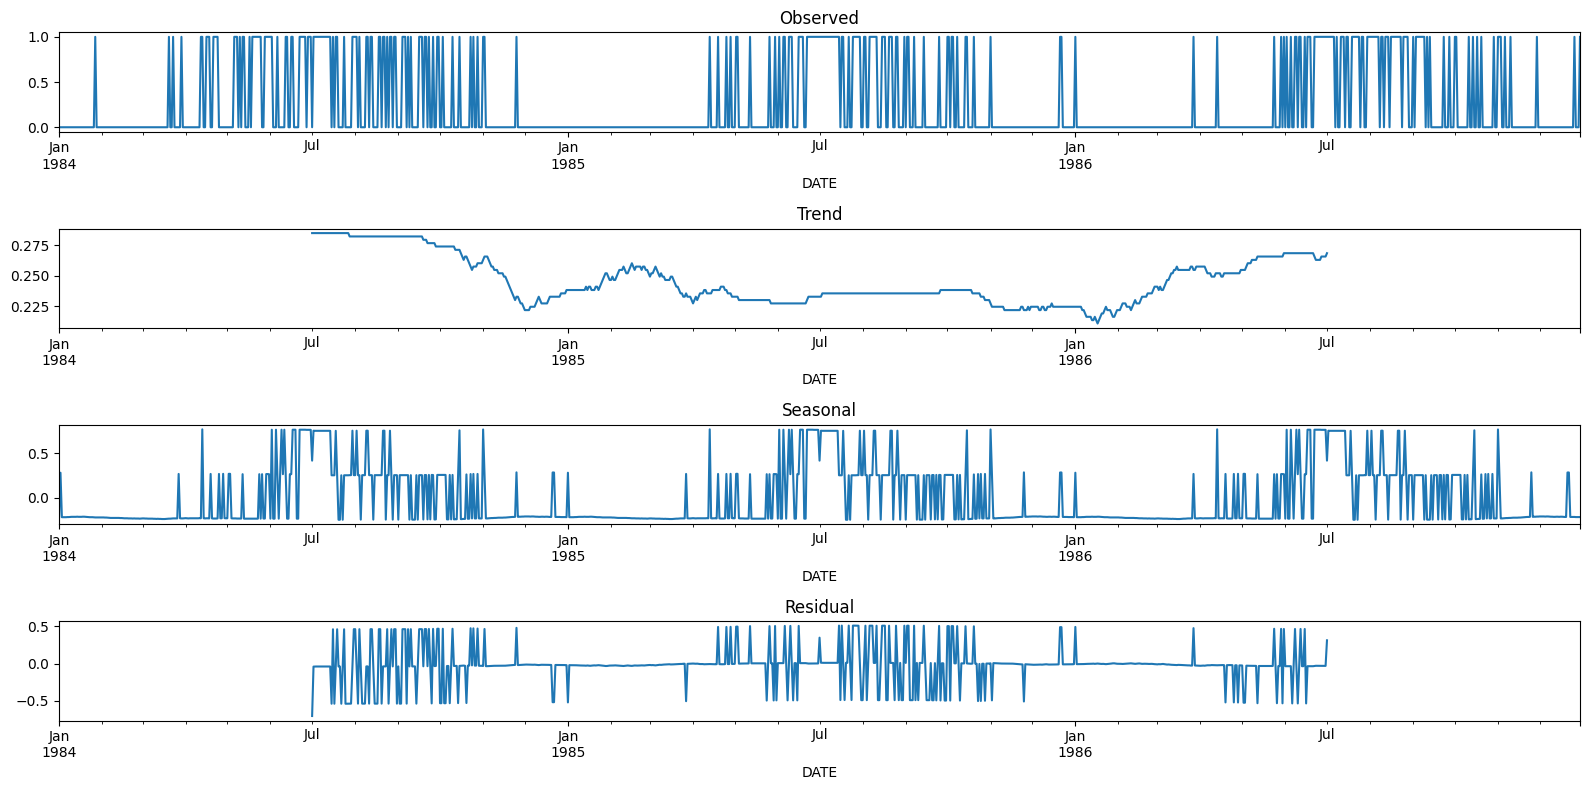

In [6]:
# Take only the first 3650 days for seasonal decomposition
df_3650 = df.head(1095)

# Set the date column as index for the first 3650 days
df_time_indexed_3650 = df_3650.set_index('DATE')

# Use a 365-day period to look for annual seasonal patterns
results = seasonal_decompose(df_time_indexed_3650['FIRE_START_DAY'], period=365)

# Create your own subplots with ultra wide size
fig, axes = plt.subplots(4, 1, figsize=(16, 8))
results.observed.plot(ax=axes[0], title='Observed')
results.trend.plot(ax=axes[1], title='Trend')
results.seasonal.plot(ax=axes[2], title='Seasonal')
results.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

DETAILED DATA ANALYSIS - FIRST 3 YEARS

1. DATASET OVERVIEW:
   Total records: 1,095
   Date range: 1984-01-01 00:00:00 to 1986-12-30 00:00:00
   Duration: 1094 days
   Years covered: 3

2. FIRE EVENTS ANALYSIS:
   Total fire events: 287
   Fire rate: 26.21%
   Average fires per year: 95.7

3. FEATURE STATISTICS:
       PRECIPITATION     MAX_TEMP     MIN_TEMP  AVG_WIND_SPEED   TEMP_RANGE  \
count    1095.000000  1095.000000  1095.000000     1095.000000  1095.000000   
mean        0.030192    70.810046    56.290411        7.872749    14.519635   
std         0.176623     7.309712     6.829850        1.984312     5.946388   
min         0.000000    54.000000    39.000000        3.360000     3.000000   
25%         0.000000    66.000000    52.000000        6.710000    10.000000   
50%         0.000000    71.000000    56.000000        7.610000    13.000000   
75%         0.000000    75.000000    61.000000        8.500000    17.000000   
max         2.660000    97.000000    77.000000       

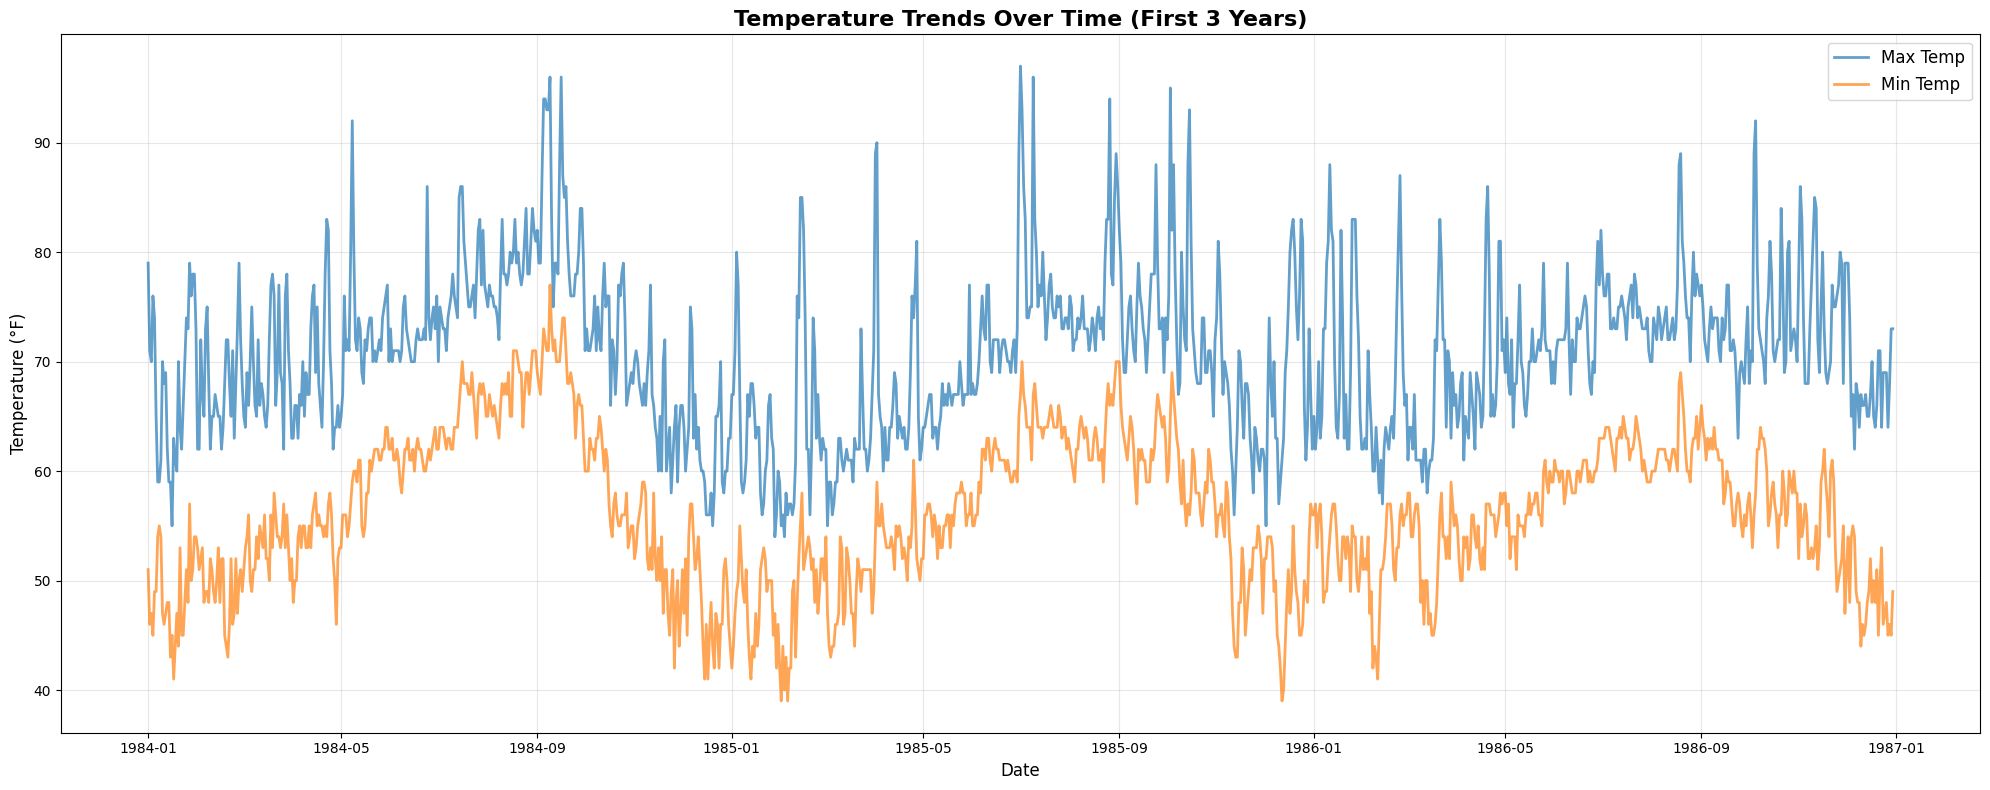

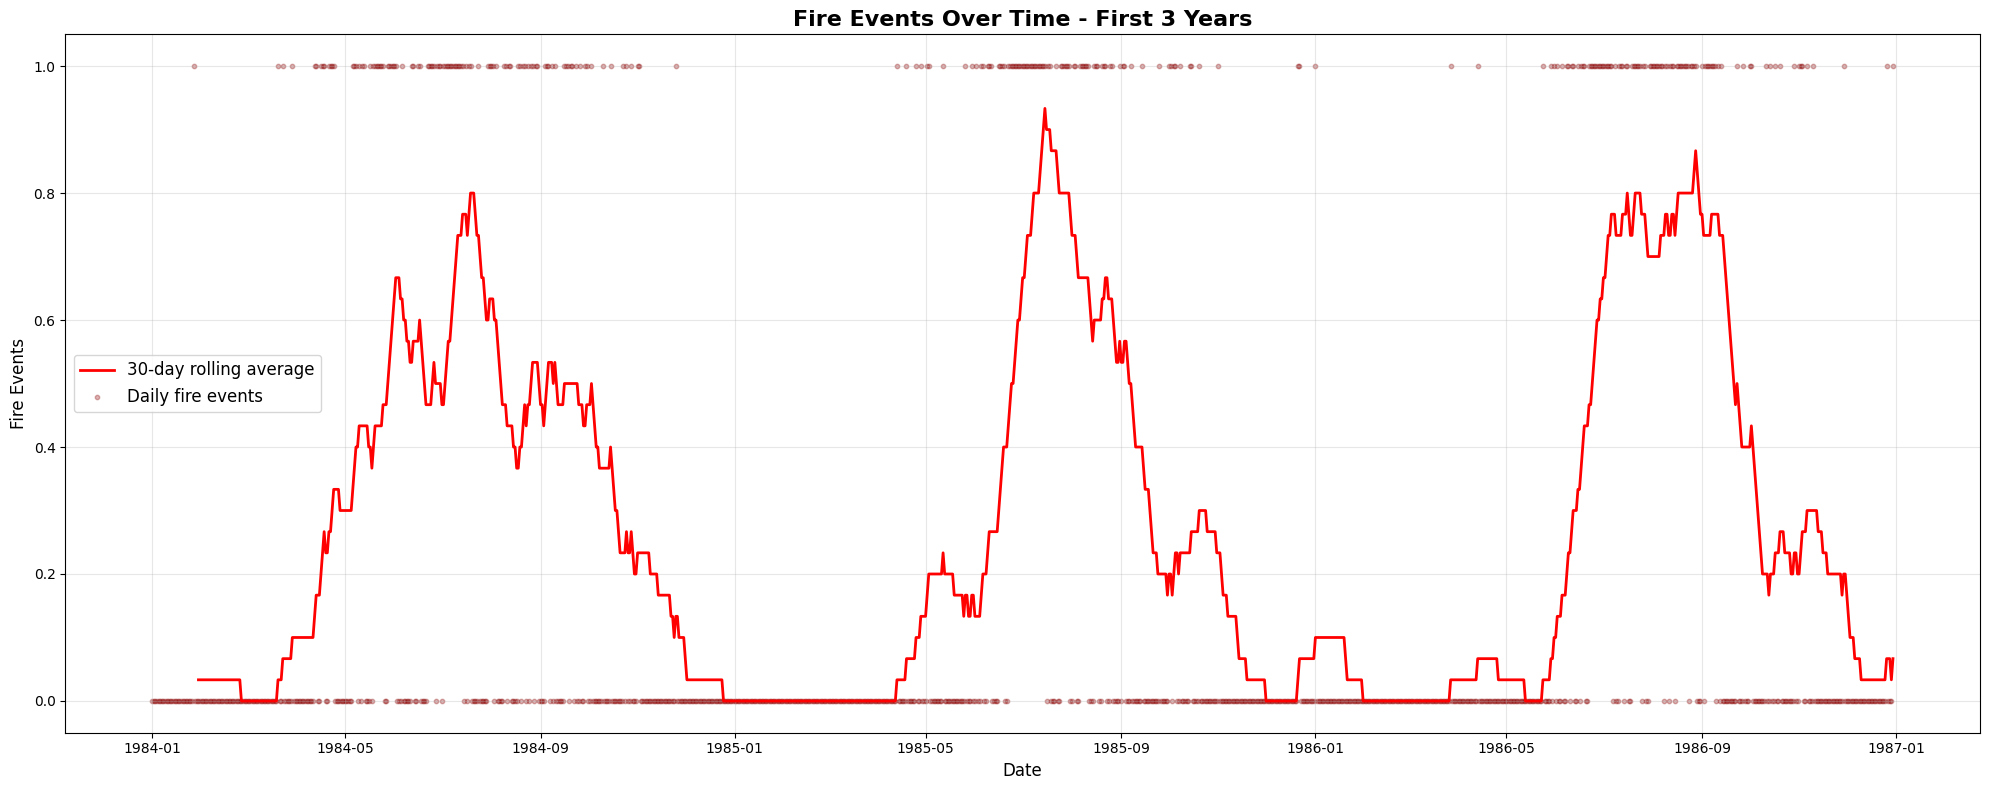

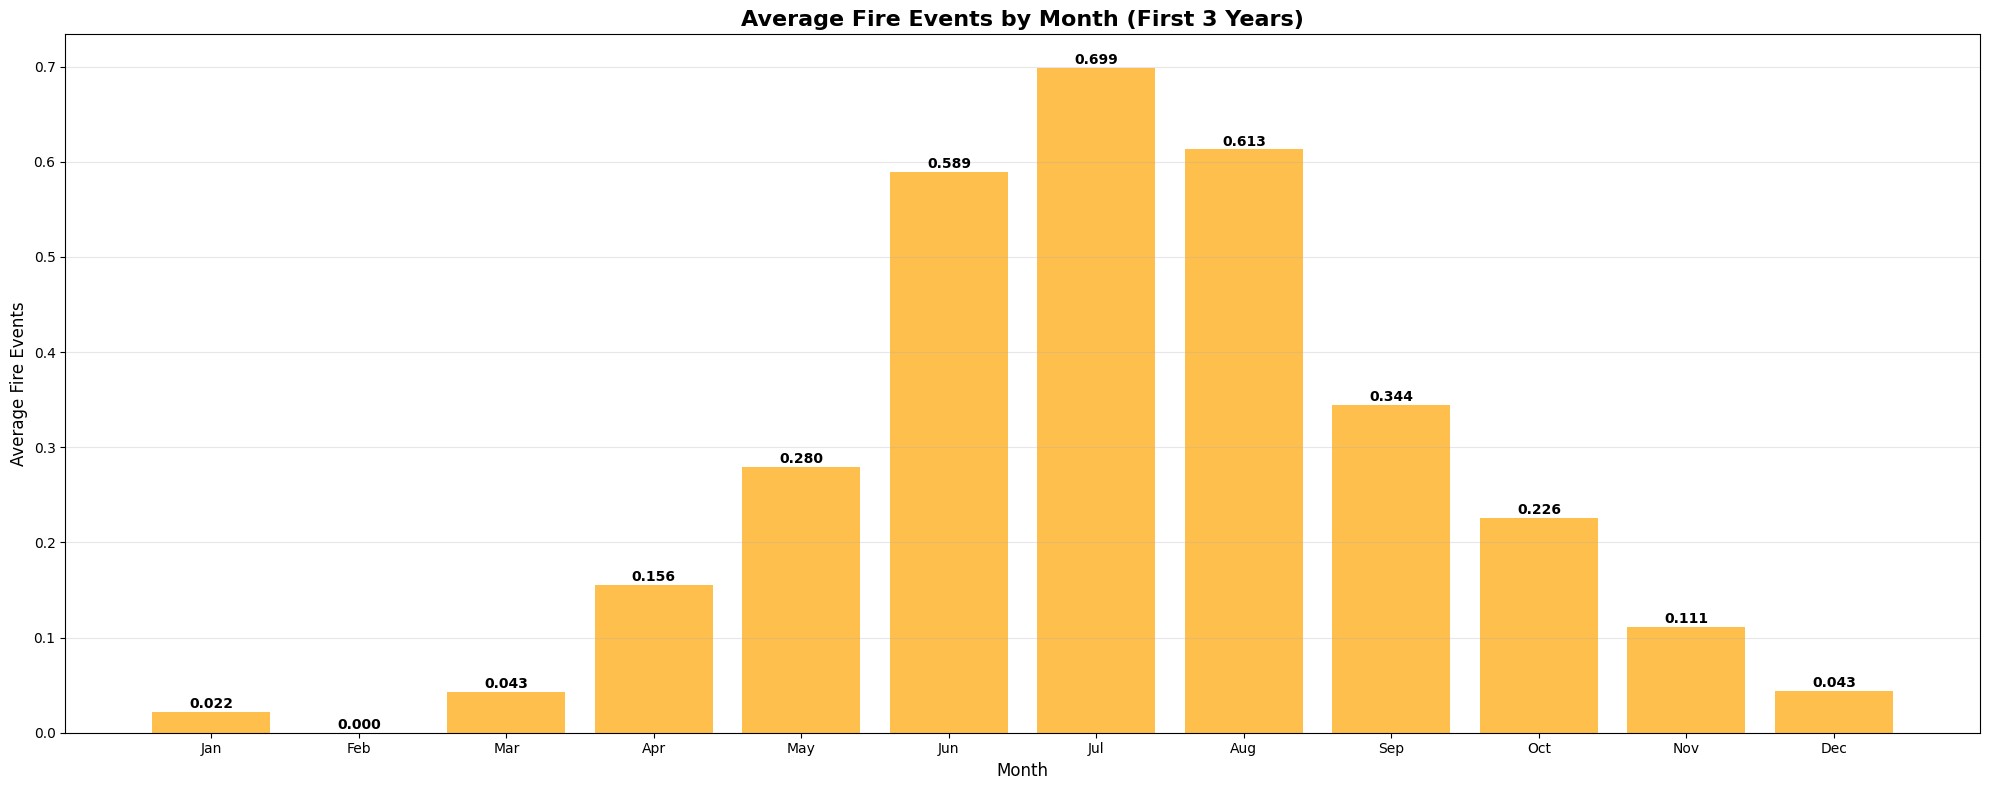

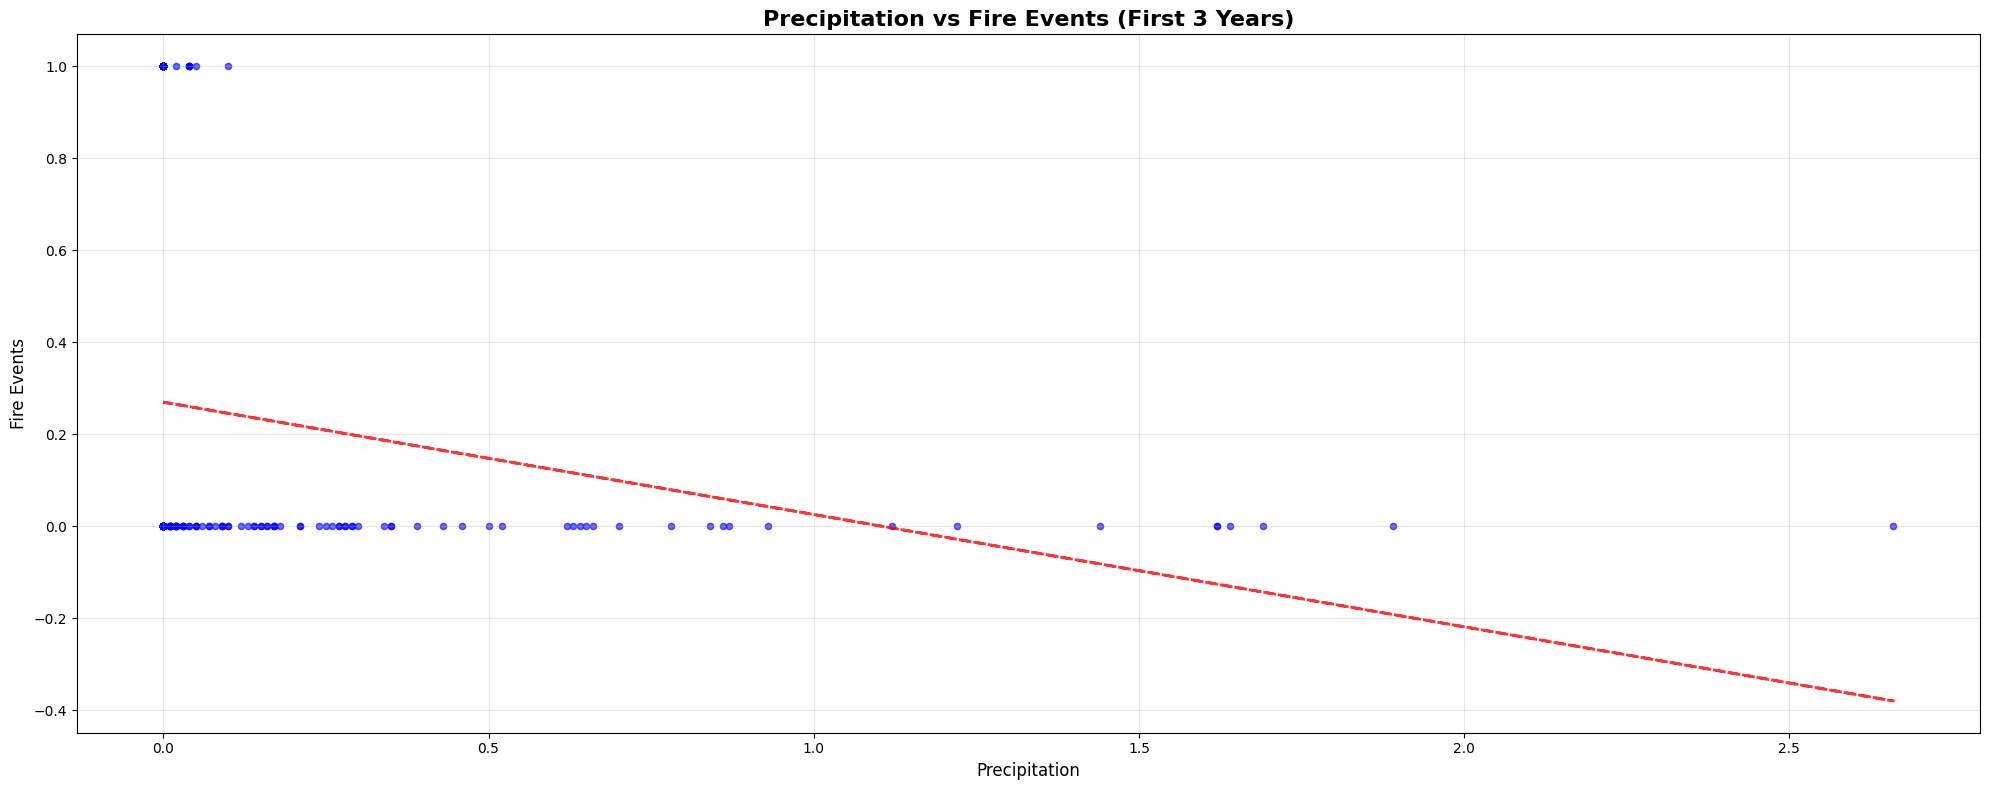

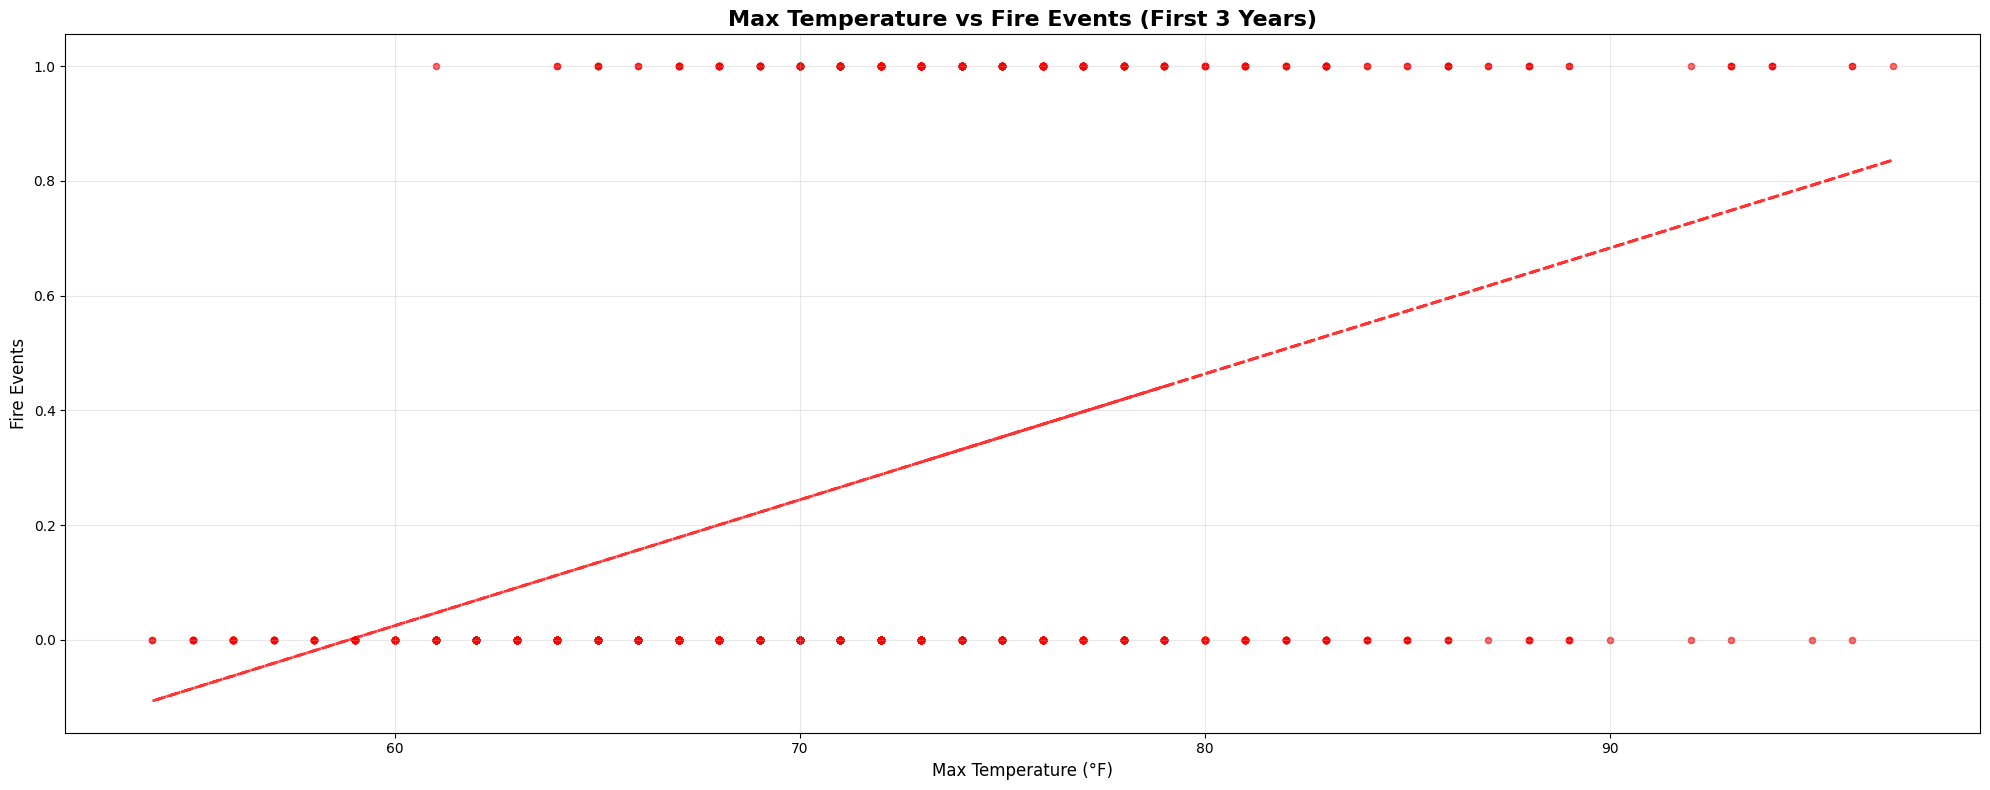

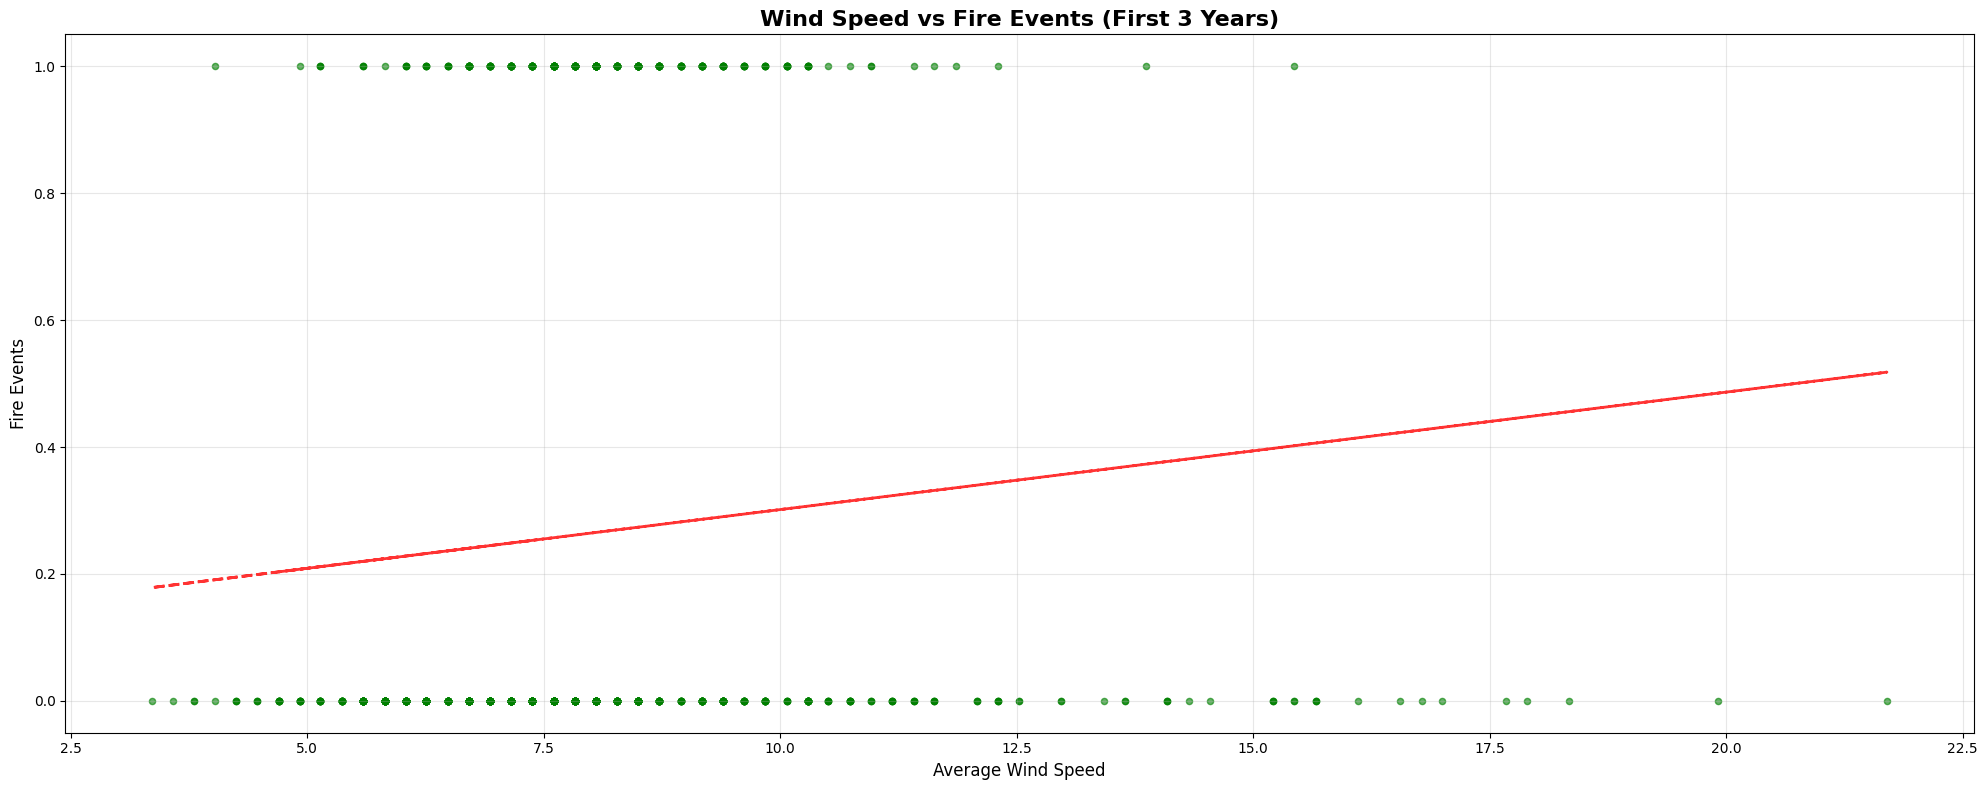


SUMMARY INSIGHTS - FIRST 3 YEARS

8. KEY FINDINGS:
   • Dataset covers 3 years
   • 26.9% of days had fire events
   • Strongest correlation with fire events: Summer (0.491)
   • Weakest correlation with fire events: Winter (-0.312)
   • Peak fire month: July
   • Average temperature range: 14.5°F
   • Maximum temperature range: 38.0°F
   • Year with most fires: 1984 (104 fires)

Analysis complete for first 3 years!


In [7]:
# Set date as index for analysis
df_time_indexed = df.set_index('DATE')

# Take only first 3 years (approximately 1095 days)
df_3years = df_time_indexed.head(1095)

# 1. BASIC STATISTICS
print("="*60)
print("DETAILED DATA ANALYSIS - FIRST 3 YEARS")
print("="*60)

print("\n1. DATASET OVERVIEW:")
print(f"   Total records: {len(df_3years):,}")
print(f"   Date range: {df_3years.index.min()} to {df_3years.index.max()}")
print(f"   Duration: {(df_3years.index.max() - df_3years.index.min()).days} days")
print(f"   Years covered: {df_3years.index.max().year - df_3years.index.min().year + 1}")

print("\n2. FIRE EVENTS ANALYSIS:")
fire_events = df_3years['FIRE_START_DAY'].sum()
fire_rate = (fire_events / len(df_3years)) * 100
print(f"   Total fire events: {fire_events:,}")
print(f"   Fire rate: {fire_rate:.2f}%")
print(f"   Average fires per year: {fire_events / 3:.1f}")

print("\n3. FEATURE STATISTICS:")
print(df_3years.describe())

# 2. TEMPORAL ANALYSIS
print("\n" + "="*60)
print("TEMPORAL PATTERNS ANALYSIS - FIRST 3 YEARS")
print("="*60)

# Monthly fire patterns
monthly_fires = df_3years.groupby(pd.to_datetime(df_3years.index).month)['FIRE_START_DAY'].agg(['mean', 'sum', 'count'])
print("\n4. MONTHLY FIRE PATTERNS:")
for month in range(1, 13):
    month_name = pd.Timestamp(2020, month, 1).strftime('%B')
    mean_fires = monthly_fires.loc[month, 'mean']
    total_fires = monthly_fires.loc[month, 'sum']
    print(f"   {month_name:9}: {mean_fires:.4f} avg, {total_fires:4.0f} total")

# Seasonal analysis
seasonal_fires = df_3years.groupby(['Winter', 'Spring', 'Summer', 'Fall'])['FIRE_START_DAY'].agg(['mean', 'sum'])
print("\n5. SEASONAL FIRE PATTERNS:")
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    if i < len(seasonal_fires):
        mean_fires = seasonal_fires.iloc[i]['mean']
        total_fires = seasonal_fires.iloc[i]['sum']
        print(f"   {season:6}: {mean_fires:.4f} avg, {total_fires:4.0f} total")

# 3. CORRELATION ANALYSIS
print("\n" + "="*60)
print("CORRELATION ANALYSIS - FIRST 3 YEARS")
print("="*60)

# Correlation with fire events
correlations = df_3years.corr()['FIRE_START_DAY'].sort_values(ascending=False)
print("\n6. FEATURE CORRELATIONS WITH FIRE EVENTS:")
for feature, corr in correlations.items():
    if feature != 'FIRE_START_DAY':
        print(f"   {feature:20}: {corr:6.3f}")

# 4. YEARLY BREAKDOWN
print("\n" + "="*60)
print("YEARLY BREAKDOWN - FIRST 3 YEARS")
print("="*60)

# Yearly trends
yearly_stats = df_3years.groupby(pd.to_datetime(df_3years.index).year).agg({
    'FIRE_START_DAY': ['sum', 'mean'],
    'MAX_TEMP': 'mean',
    'MIN_TEMP': 'mean',
    'PRECIPITATION': 'sum',
    'AVG_WIND_SPEED': 'mean'
})

print("\n7. YEARLY STATISTICS:")
print("   Year | Fires | Fire Rate | Avg Max Temp | Avg Min Temp | Total Precip | Avg Wind")
print("   " + "-"*70)
for year in yearly_stats.index:
    fires = yearly_stats.loc[year, ('FIRE_START_DAY', 'sum')]
    fire_rate = pd.to_numeric(yearly_stats.loc[year, ('FIRE_START_DAY', 'mean')]) * 100
    max_temp = yearly_stats.loc[year, ('MAX_TEMP', 'mean')]
    min_temp = yearly_stats.loc[year, ('MIN_TEMP', 'mean')]
    precip = yearly_stats.loc[year, ('PRECIPITATION', 'sum')]
    wind = yearly_stats.loc[year, ('AVG_WIND_SPEED', 'mean')]
    print(f"   {year:4} | {fires:5.0f} | {fire_rate:8.2f}% | {max_temp:11.1f}°F | {min_temp:11.1f}°F | {precip:12.1f} | {wind:8.1f}")

# 5. SEPARATE VISUALIZATIONS
print("\n" + "="*60)
print("GENERATING 6 SEPARATE VISUALIZATIONS - FIRST 3 YEARS")
print("="*60)

# 1. Temperature Trends Over Time
plt.figure(figsize=(20, 8))
plt.plot(df_3years.index, df_3years['MAX_TEMP'], label='Max Temp', alpha=0.7, linewidth=2)
plt.plot(df_3years.index, df_3years['MIN_TEMP'], label='Min Temp', alpha=0.7, linewidth=2)
plt.title('Temperature Trends Over Time (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Fire Events Over Time
plt.figure(figsize=(20, 8))
plt.plot(df_3years.index, df_3years['FIRE_START_DAY'].rolling(30).mean(), label='30-day rolling average', color='red', linewidth=2)
plt.scatter(df_3years.index, df_3years['FIRE_START_DAY'], alpha=0.3, s=10, color='darkred', label='Daily fire events')
plt.title('Fire Events Over Time - First 3 Years', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Monthly Fire Patterns
plt.figure(figsize=(20, 8))
monthly_avg = df_3years.groupby(pd.to_datetime(df_3years.index).month)['FIRE_START_DAY'].mean()
bars = plt.bar(range(1,13), np.asarray(monthly_avg.values), color='orange', alpha=0.7)
plt.title('Average Fire Events by Month (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Fire Events', fontsize=12)
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Precipitation vs Fire Events
plt.figure(figsize=(20, 8))
plt.scatter(df_3years['PRECIPITATION'], df_3years['FIRE_START_DAY'], alpha=0.6, s=20, color='blue')
plt.title('Precipitation vs Fire Events (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Precipitation', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df_3years['PRECIPITATION'], df_3years['FIRE_START_DAY'], 1)
p = np.poly1d(z)
plt.plot(df_3years['PRECIPITATION'], p(df_3years['PRECIPITATION']), "r--", alpha=0.8, linewidth=2)
plt.tight_layout()
plt.show()

# 5. Temperature vs Fire Events
plt.figure(figsize=(20, 8))
plt.scatter(df_3years['MAX_TEMP'], df_3years['FIRE_START_DAY'], alpha=0.6, s=20, color='red')
plt.title('Max Temperature vs Fire Events (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Max Temperature (°F)', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df_3years['MAX_TEMP'], df_3years['FIRE_START_DAY'], 1)
p = np.poly1d(z)
plt.plot(df_3years['MAX_TEMP'], p(df_3years['MAX_TEMP']), "r--", alpha=0.8, linewidth=2)
plt.tight_layout()
plt.show()

# 6. Wind Speed vs Fire Events
plt.figure(figsize=(20, 8))
plt.scatter(df_3years['AVG_WIND_SPEED'], df_3years['FIRE_START_DAY'], alpha=0.6, s=20, color='green')
plt.title('Wind Speed vs Fire Events (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Average Wind Speed', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df_3years['AVG_WIND_SPEED'], df_3years['FIRE_START_DAY'], 1)
p = np.poly1d(z)
plt.plot(df_3years['AVG_WIND_SPEED'], p(df_3years['AVG_WIND_SPEED']), "r--", alpha=0.8, linewidth=2)
plt.tight_layout()
plt.show()

# 6. SUMMARY STATISTICS
print("\n" + "="*60)
print("SUMMARY INSIGHTS - FIRST 3 YEARS")
print("="*60)

print(f"\n8. KEY FINDINGS:")
print(f"   • Dataset covers {df_3years.index.max().year - df_3years.index.min().year + 1} years")
print(f"   • {fire_rate:.1f}% of days had fire events")
print(f"   • Strongest correlation with fire events: {correlations.index[1]} ({correlations.iloc[1]:.3f})")
print(f"   • Weakest correlation with fire events: {correlations.index[-1]} ({correlations.iloc[-1]:.3f})")

# Find peak fire month
peak_month = int(monthly_fires['mean'].idxmax())
peak_month_name = pd.Timestamp(2020, peak_month, 1).strftime('%B')
print(f"   • Peak fire month: {peak_month_name}")

# Temperature range analysis
temp_range = df_3years['MAX_TEMP'] - df_3years['MIN_TEMP']
print(f"   • Average temperature range: {temp_range.mean():.1f}°F")
print(f"   • Maximum temperature range: {temp_range.max():.1f}°F")

# Year with most fires
year_most_fires = yearly_stats[('FIRE_START_DAY', 'sum')].idxmax()
fires_in_peak_year = yearly_stats.loc[year_most_fires, ('FIRE_START_DAY', 'sum')]
print(f"   • Year with most fires: {year_most_fires} ({fires_in_peak_year:.0f} fires)")

print("\nAnalysis complete for first 3 years!")

In [8]:
# Previous day effects
df_3years['PREV_DAY_FIRE'] = df_3years['FIRE_START_DAY'].shift(1)
df_3years['PREV_DAY_TEMP'] = df_3years['MAX_TEMP'].shift(1)
df_3years['PREV_DAY_PRECIP'] = df_3years['PRECIPITATION'].shift(1)

# Fire clustering analysis
fire_days = df_3years[df_3years['FIRE_START_DAY'] == 1]
consecutive_fires = 0
max_consecutive = 0
for i in range(1, len(df_3years)):
    if df_3years['FIRE_START_DAY'].iloc[i] == 1 and df_3years['FIRE_START_DAY'].iloc[i-1] == 1:
        consecutive_fires += 1
        max_consecutive = max(max_consecutive, consecutive_fires)
    else:
        consecutive_fires = 0

print(f"Maximum consecutive fire days: {max_consecutive}")

Maximum consecutive fire days: 23


C:\Users\nakul\AppData\Local\Temp\ipykernel_91564\867543843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3years['PREV_DAY_FIRE'] = df_3years['FIRE_START_DAY'].shift(1)
C:\Users\nakul\AppData\Local\Temp\ipykernel_91564\867543843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3years['PREV_DAY_TEMP'] = df_3years['MAX_TEMP'].shift(1)
C:\Users\nakul\AppData\Local\Temp\ipykernel_91564\867543843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [9]:
print(f"\nSplitting data: {TRAIN_RATIO:.0%} training, {1-TRAIN_RATIO:.0%} testing")

# Calculate split point
split_idx = int(len(df) * TRAIN_RATIO)

# Split data
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Training set: {len(train_df)} samples")
print(f"Testing set: {len(test_df)} samples")


Splitting data: 80% training, 20% testing
Training set: 11976 samples
Testing set: 2994 samples


In [10]:
def create_sequences(df, features, target, sequence_length):
    """Create sequences for LSTM model"""
    X, y = [], []
    for i in range(sequence_length, len(df)):
        # Get sequence of features
        sequence = features[i-sequence_length:i]
        X.append(sequence)
        y.append(target.iloc[i])
    return np.array(X), np.array(y)

print("\nPreparing data for training...")

# Initialize scaler
scaler = StandardScaler()

# Scale features
train_features = train_df[FEATURE_COLUMNS].values
test_features = test_df[FEATURE_COLUMNS].values

# Fit scaler on training data only and transform both
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Create sequences
X_train, y_train = create_sequences(
    train_df, 
    train_features_scaled, 
    train_df[TARGET_COLUMN],
    SEQUENCE_LENGTH
)

X_test, y_test = create_sequences(
    test_df, 
    test_features_scaled, 
    test_df[TARGET_COLUMN],
    SEQUENCE_LENGTH
)

print(f"Training sequences: {X_train.shape}")
print(f"Testing sequences: {X_test.shape}")


Preparing data for training...
Training sequences: (11969, 7, 15)
Testing sequences: (2987, 7, 15)


In [11]:
print("\nBuilding and training LSTM model...")

# Build Model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(16, return_sequences=False),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Calculate aggressive class weights to favor fire prediction
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Increase weight for fire class (class 1)
class_weights_array[1] *= 3.0  # Triple the weight for fire class
class_weight_dict = dict(zip(np.unique(y_train), class_weights_array))
print(f"Class weights (fire class boosted): {class_weight_dict}")

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True,
    min_delta=0
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=30,
    min_lr=0
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

model.save('fire_model.keras')


Building and training LSTM model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             6144      
                                                                 
 dropout (Dropout)           (None, 7, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,425

In [12]:
test_features_scaled = np.array(test_features_scaled)


print(f"\nPerforming iterative forecasting with threshold {THRESHOLD}...")

predictions = []
actual_values = []
prediction_dates = []
prediction_probabilities = []

# Start from the 8th day (index 7) in the test set
for i in range(SEQUENCE_LENGTH, len(test_df)):
    # Get the 7-day window of scaled features
    window_features = test_features_scaled[i-SEQUENCE_LENGTH:i]
    window_features = window_features.reshape(1, SEQUENCE_LENGTH, -1)
    
    # Make prediction
    pred_proba = model.predict(window_features, verbose=0)
    pred = (pred_proba > THRESHOLD).astype(int)[0][0]
    
    # Store results
    predictions.append(pred)
    prediction_probabilities.append(pred_proba[0][0])
    actual_values.append(test_df.iloc[i][TARGET_COLUMN])
    prediction_dates.append(test_df.iloc[i]['DATE'])
    
    print(f"Date: {test_df.iloc[i]['DATE'].strftime('%Y-%m-%d')}, "
          f"Predicted: {pred} (prob: {pred_proba[0][0]:.4f}), "
          f"Actual: {test_df.iloc[i][TARGET_COLUMN]}")

print(f"\nPrediction probabilities range: {min(prediction_probabilities):.4f} to {max(prediction_probabilities):.4f}")
print(f"Mean prediction probability: {np.mean(prediction_probabilities):.4f}")
print(f"Predictions with value 1: {sum(predictions)} out of {len(predictions)}")


Performing iterative forecasting with threshold 0.5...
Date: 2016-10-22, Predicted: 1 (prob: 0.8372), Actual: 0
Date: 2016-10-23, Predicted: 1 (prob: 0.8275), Actual: 0
Date: 2016-10-24, Predicted: 1 (prob: 0.8164), Actual: 1
Date: 2016-10-25, Predicted: 1 (prob: 0.7992), Actual: 0
Date: 2016-10-26, Predicted: 1 (prob: 0.8081), Actual: 0
Date: 2016-10-22, Predicted: 1 (prob: 0.8372), Actual: 0
Date: 2016-10-23, Predicted: 1 (prob: 0.8275), Actual: 0
Date: 2016-10-24, Predicted: 1 (prob: 0.8164), Actual: 1
Date: 2016-10-25, Predicted: 1 (prob: 0.7992), Actual: 0
Date: 2016-10-26, Predicted: 1 (prob: 0.8081), Actual: 0
Date: 2016-10-27, Predicted: 1 (prob: 0.8143), Actual: 0
Date: 2016-10-28, Predicted: 1 (prob: 0.8136), Actual: 0
Date: 2016-10-29, Predicted: 1 (prob: 0.7960), Actual: 1
Date: 2016-10-30, Predicted: 1 (prob: 0.8150), Actual: 0
Date: 2016-10-31, Predicted: 1 (prob: 0.7735), Actual: 0
Date: 2016-11-01, Predicted: 1 (prob: 0.7813), Actual: 0
Date: 2016-10-27, Predicted: 1 (


Creating visualization...


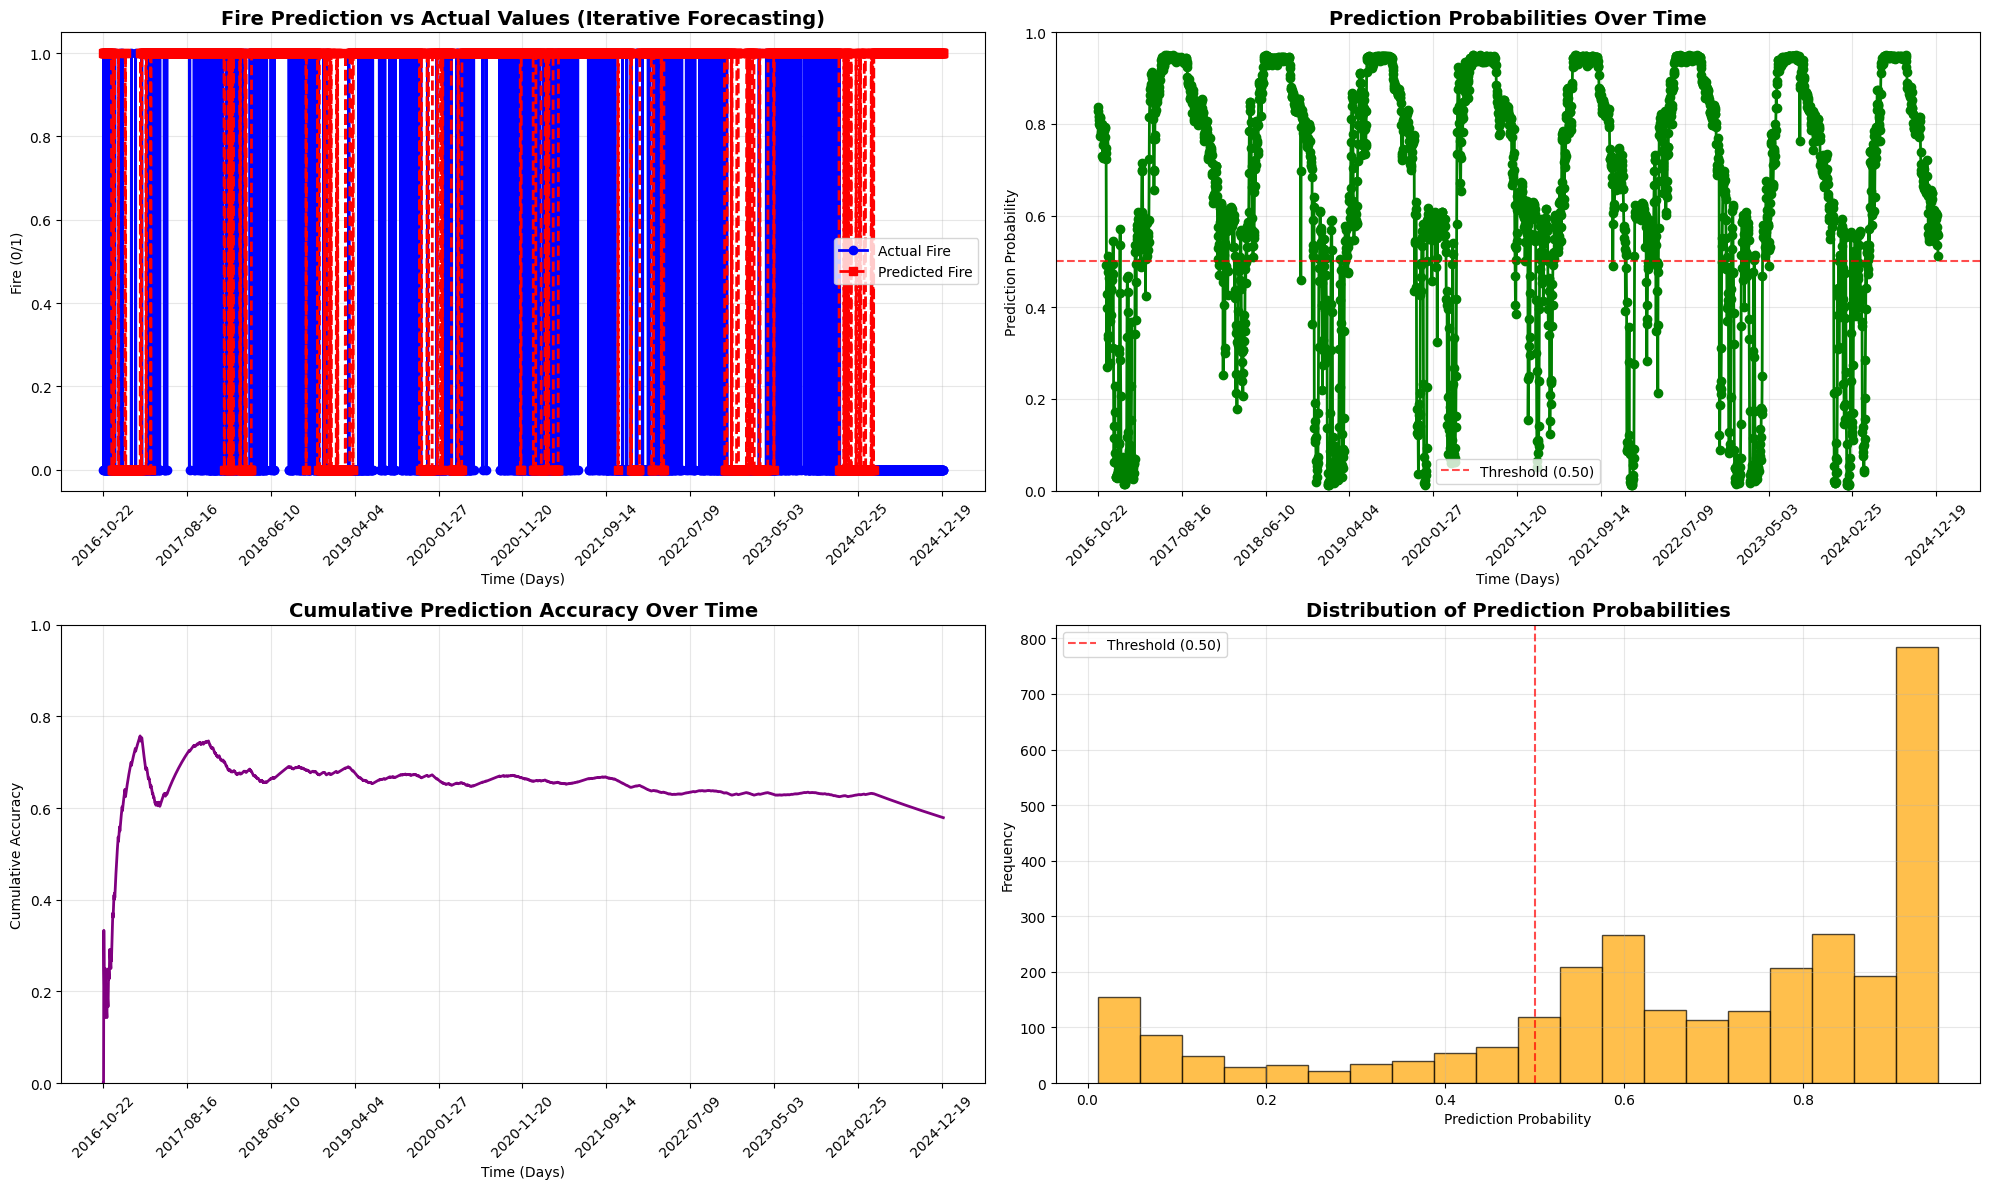


Final Iterative Forecasting Accuracy: 0.5792
Total predictions made: 2987
Correct predictions: 1730
Predicted fire days: 2377
Actual fire days: 1200


In [13]:
print("\nCreating visualization...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Time series of predictions vs actual
dates = [d.strftime('%Y-%m-%d') for d in prediction_dates]
x_indices = range(len(dates))

ax1.plot(x_indices, actual_values, 'b-', label='Actual Fire', linewidth=2, marker='o')
ax1.plot(x_indices, predictions, 'r--', label='Predicted Fire', linewidth=2, marker='s')
ax1.set_title('Fire Prediction vs Actual Values (Iterative Forecasting)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Fire (0/1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Set x-axis labels for better readability
step = max(1, len(dates) // 10)
ax1.set_xticks(x_indices[::step])
ax1.set_xticklabels(dates[::step], rotation=45)

# Plot 2: Prediction probabilities over time
ax2.plot(x_indices, prediction_probabilities, 'g-', linewidth=2, marker='o')
ax2.axhline(y=THRESHOLD, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({THRESHOLD:.2f})')
ax2.set_title('Prediction Probabilities Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (Days)')
ax2.set_ylabel('Prediction Probability')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Set x-axis labels
ax2.set_xticks(x_indices[::step])
ax2.set_xticklabels(dates[::step], rotation=45)

# Plot 3: Cumulative accuracy over time
correct_predictions = [1 if p == a else 0 for p, a in zip(predictions, actual_values)]
cumulative_accuracy = np.cumsum(correct_predictions) / np.arange(1, len(correct_predictions) + 1)

ax3.plot(x_indices, cumulative_accuracy, 'purple', linewidth=2)
ax3.set_title('Cumulative Prediction Accuracy Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time (Days)')
ax3.set_ylabel('Cumulative Accuracy')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Set x-axis labels
ax3.set_xticks(x_indices[::step])
ax3.set_xticklabels(dates[::step], rotation=45)

# Plot 4: Distribution of prediction probabilities
ax4.hist(prediction_probabilities, bins=20, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(x=THRESHOLD, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({THRESHOLD:.2f})')
ax4.set_title('Distribution of Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.set_xlabel('Prediction Probability')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
final_accuracy = np.mean(correct_predictions)
print(f"\nFinal Iterative Forecasting Accuracy: {final_accuracy:.4f}")
print(f"Total predictions made: {len(predictions)}")
print(f"Correct predictions: {sum(correct_predictions)}")
print(f"Predicted fire days: {sum(predictions)}")
print(f"Actual fire days: {sum(actual_values)}")

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("="*60)
print("LINEAR REGRESSION ANALYSIS")
print("="*60)

# Prepare data for linear regression
# Using the full dataset for comprehensive analysis
X_linear = df[FEATURE_COLUMNS].values
y_linear = df[TARGET_COLUMN].values

# Split into train and test (same split as before)
split_idx = int(len(df) * TRAIN_RATIO)
X_train_lr = X_linear[:split_idx]
y_train_lr = y_linear[:split_idx]
X_test_lr = X_linear[split_idx:]
y_test_lr = y_linear[split_idx:]

# Scale the features
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
X_test_lr_scaled = scaler_lr.transform(X_test_lr)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr_scaled, y_train_lr)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_lr_scaled)
y_test_pred_lr = lr_model.predict(X_test_lr_scaled)

# Convert predictions to binary (threshold at 0.5)
y_train_pred_binary = (y_train_pred_lr > THRESHOLD).astype(int)
y_test_pred_binary = (y_test_pred_lr > THRESHOLD).astype(int)

# Calculate metrics
print("\n1. REGRESSION METRICS:")
print(f"\nTraining Set:")
print(f"   R² Score: {r2_score(y_train_lr, y_train_pred_lr):.4f}")
print(f"   Mean Squared Error: {mean_squared_error(y_train_lr, y_train_pred_lr):.4f}")
print(f"   Mean Absolute Error: {mean_absolute_error(y_train_lr, y_train_pred_lr):.4f}")

print(f"\nTesting Set:")
print(f"   R² Score: {r2_score(y_test_lr, y_test_pred_lr):.4f}")
print(f"   Mean Squared Error: {mean_squared_error(y_test_lr, y_test_pred_lr):.4f}")
print(f"   Mean Absolute Error: {mean_absolute_error(y_test_lr, y_test_pred_lr):.4f}")

# Classification metrics
print("\n2. CLASSIFICATION METRICS (Binary Threshold):")
print(f"\nTraining Set:")
print(f"   Accuracy: {accuracy_score(y_train_lr, y_train_pred_binary):.4f}")
print(f"   F1 Score: {f1_score(y_train_lr, y_train_pred_binary):.4f}")

print(f"\nTesting Set:")
print(f"   Accuracy: {accuracy_score(y_test_lr, y_test_pred_binary):.4f}")
print(f"   F1 Score: {f1_score(y_test_lr, y_test_pred_binary):.4f}")

# Feature importance (coefficients)
print("\n3. FEATURE IMPORTANCE (Coefficients):")
feature_importance = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(feature_importance.to_string(index=False))



LINEAR REGRESSION ANALYSIS

1. REGRESSION METRICS:

Training Set:
   R² Score: 0.2929
   Mean Squared Error: 0.1525
   Mean Absolute Error: 0.3151

Testing Set:
   R² Score: 0.2627
   Mean Squared Error: 0.1772
   Mean Absolute Error: 0.3632

2. CLASSIFICATION METRICS (Binary Threshold):

Training Set:
   Accuracy: 0.7784
   F1 Score: 0.6229

Testing Set:
   Accuracy: 0.7508
   F1 Score: 0.6708

3. FEATURE IMPORTANCE (Coefficients):
              Feature  Coefficient
               Summer     0.100413
             MIN_TEMP     0.079016
             MAX_TEMP     0.070115
                 YEAR     0.056589
               Winter    -0.045853
       AVG_WIND_SPEED    -0.042630
      WIND_TEMP_RATIO     0.039383
               Spring    -0.036167
 LAGGED_PRECIPITATION    -0.023801
                MONTH     0.020956
                 Fall    -0.019009
LAGGED_AVG_WIND_SPEED     0.018702
          DAY_OF_YEAR    -0.014683
           TEMP_RANGE    -0.004441
        PRECIPITATION    -0.003289


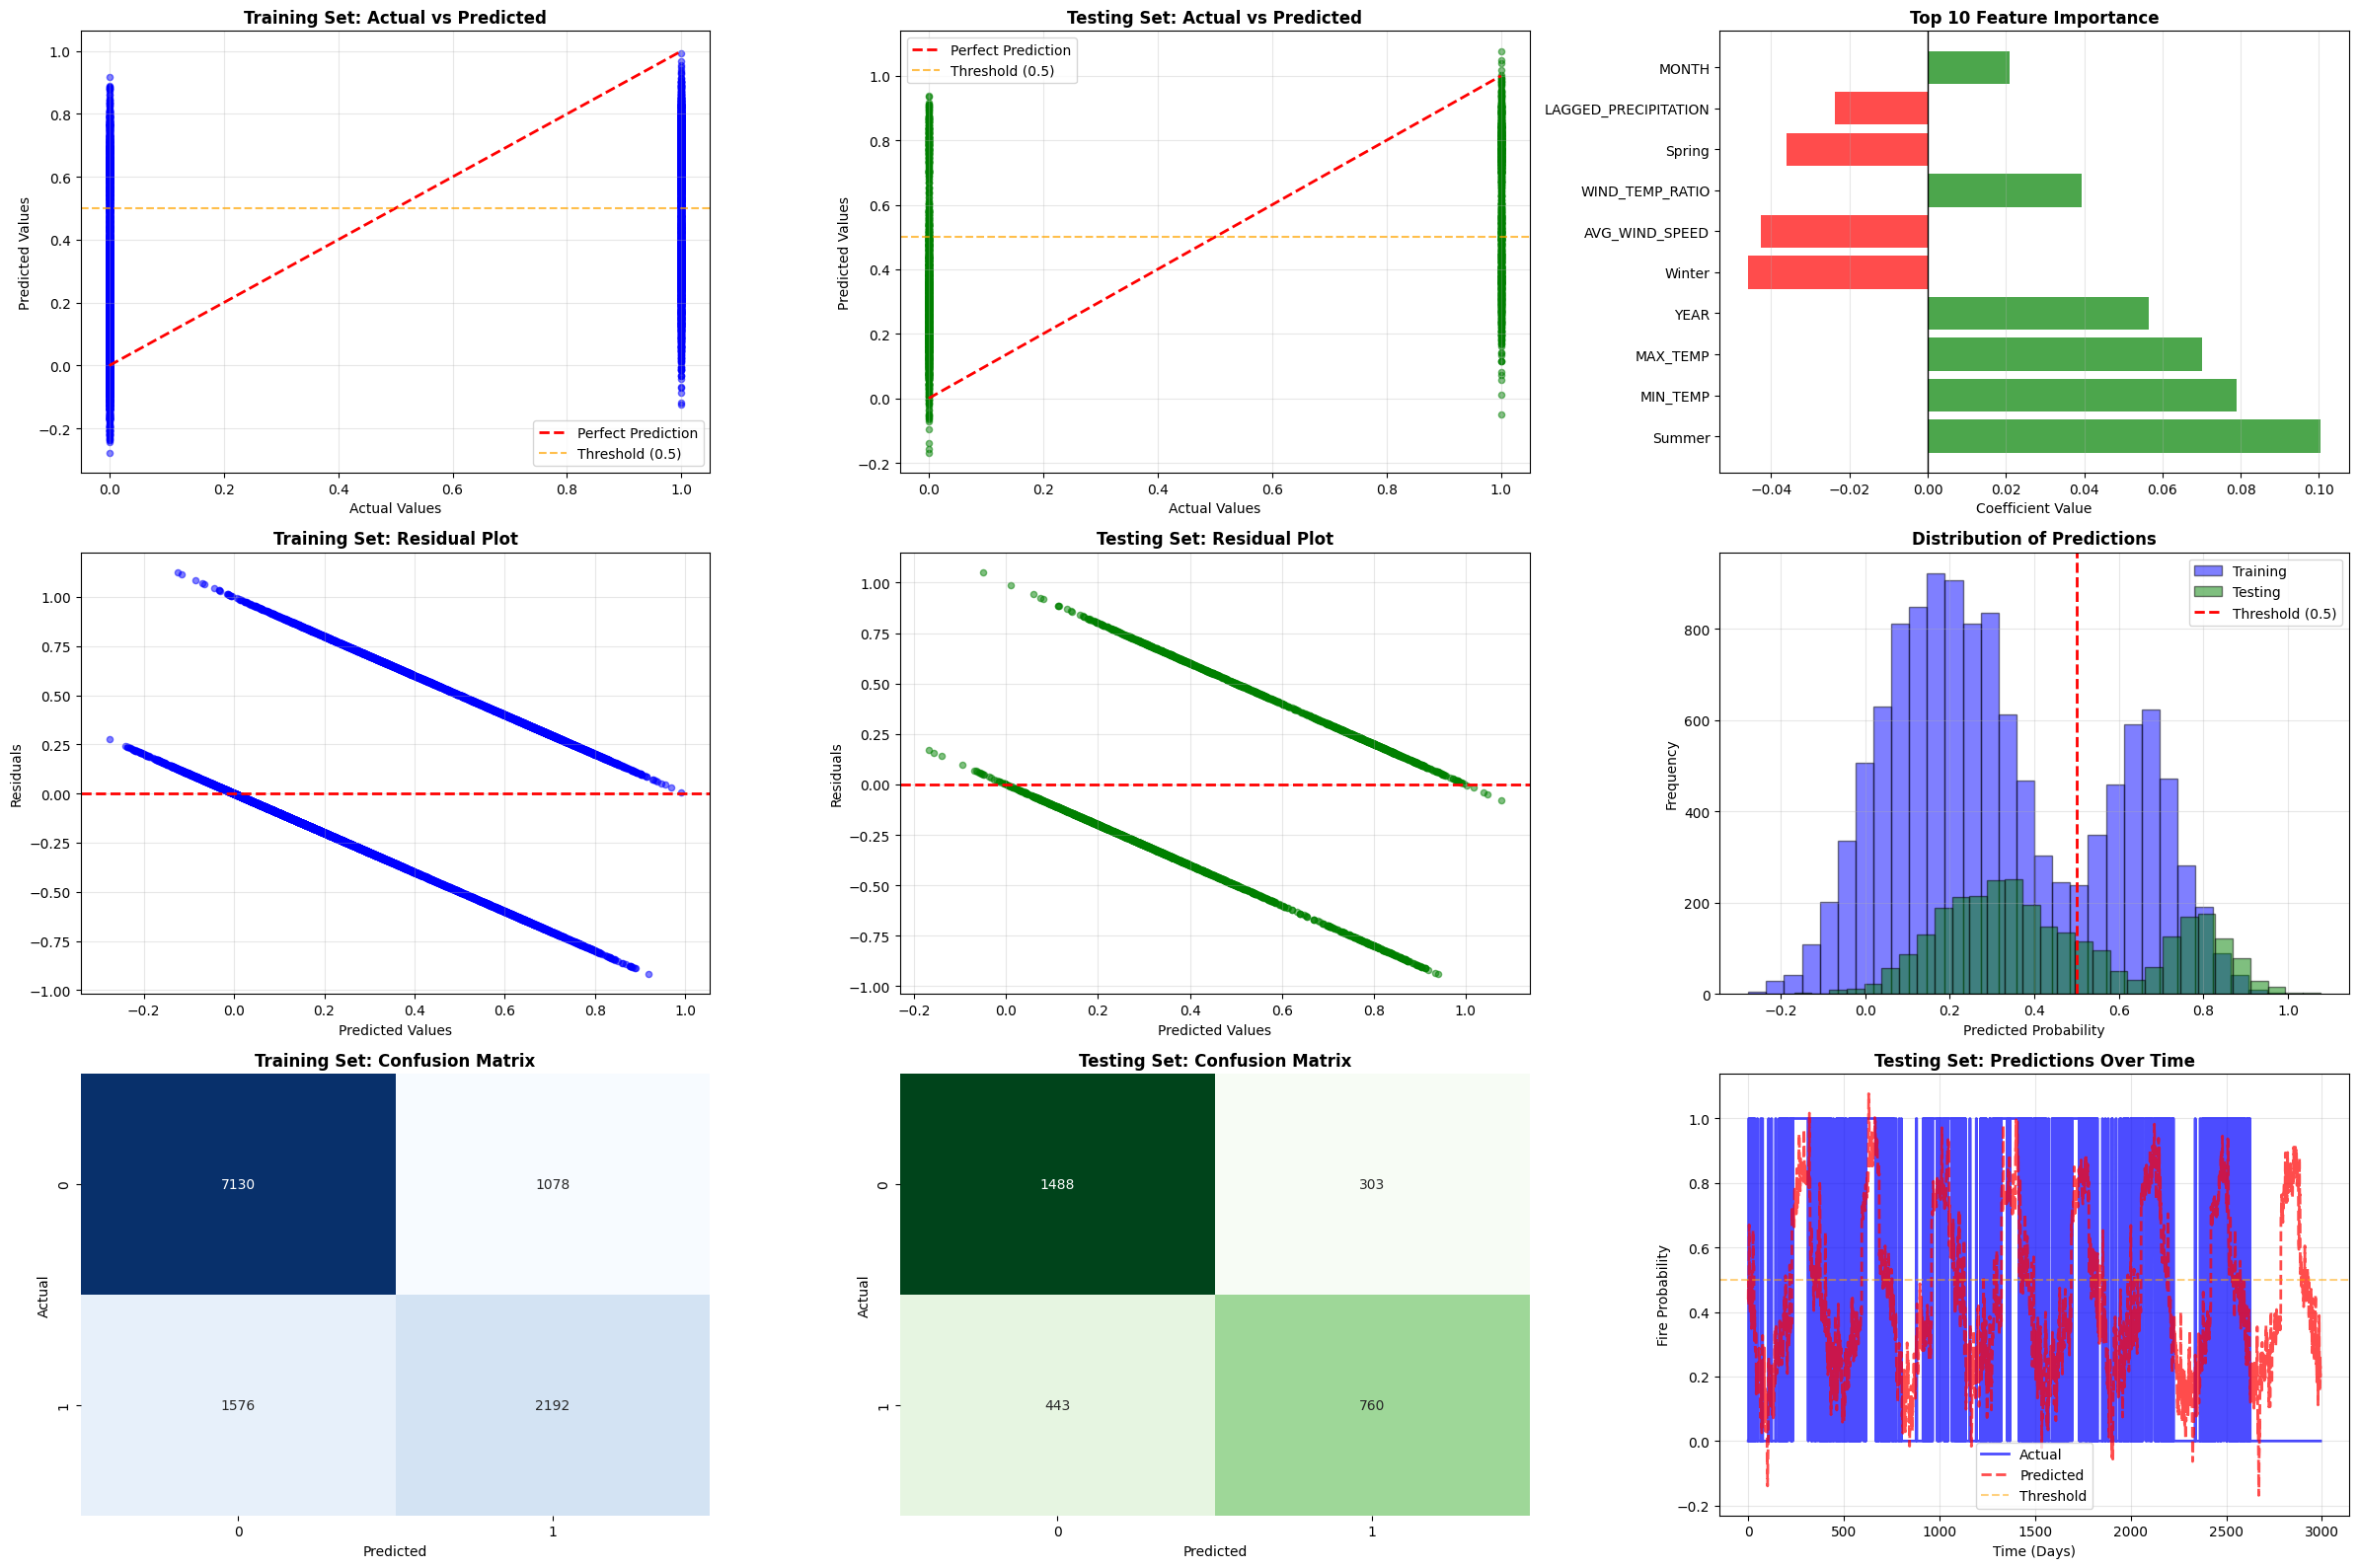


4. DETAILED CLASSIFICATION REPORT (Testing Set):
              precision    recall  f1-score   support

     No Fire       0.77      0.83      0.80      1791
        Fire       0.71      0.63      0.67      1203

    accuracy                           0.75      2994
   macro avg       0.74      0.73      0.74      2994
weighted avg       0.75      0.75      0.75      2994


5. PREDICTION STATISTICS:

Training Set:
   Predicted fires: 3270 / 11976
   Actual fires: 3768 / 11976
   Prediction range: [-0.2767, 0.9921]

Testing Set:
   Predicted fires: 1063 / 2994
   Actual fires: 1203 / 2994
   Prediction range: [-0.1685, 1.0769]

LINEAR REGRESSION ANALYSIS COMPLETE


In [18]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(24, 16))

# Plot 1: Actual vs Predicted (Training Set)
ax1 = plt.subplot(3, 3, 1)
ax1.scatter(y_train_lr, y_train_pred_lr, alpha=0.5, s=20, color='blue')
ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
ax1.axhline(y=THRESHOLD, color='orange', linestyle='--', alpha=0.7, label=f'Threshold ({THRESHOLD})')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Training Set: Actual vs Predicted', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Testing Set)
ax2 = plt.subplot(3, 3, 2)
ax2.scatter(y_test_lr, y_test_pred_lr, alpha=0.5, s=20, color='green')
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
ax2.axhline(y=THRESHOLD, color='orange', linestyle='--', alpha=0.7, label=f'Threshold ({THRESHOLD})')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Testing Set: Actual vs Predicted', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Feature Importance
ax3 = plt.subplot(3, 3, 3)
top_features = feature_importance.head(10)
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
ax3.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['Feature'])
ax3.set_xlabel('Coefficient Value')
ax3.set_title('Top 10 Feature Importance', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.axvline(x=0, color='black', linewidth=1)

# Plot 4: Residuals (Training)
ax4 = plt.subplot(3, 3, 4)
residuals_train = y_train_lr - y_train_pred_lr
ax4.scatter(y_train_pred_lr, residuals_train, alpha=0.5, s=20, color='blue')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Training Set: Residual Plot', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Residuals (Testing)
ax5 = plt.subplot(3, 3, 5)
residuals_test = y_test_lr - y_test_pred_lr
ax5.scatter(y_test_pred_lr, residuals_test, alpha=0.5, s=20, color='green')
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_xlabel('Predicted Values')
ax5.set_ylabel('Residuals')
ax5.set_title('Testing Set: Residual Plot', fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Distribution of Predictions
ax6 = plt.subplot(3, 3, 6)
ax6.hist(y_train_pred_lr, bins=30, alpha=0.5, color='blue', label='Training', edgecolor='black')
ax6.hist(y_test_pred_lr, bins=30, alpha=0.5, color='green', label='Testing', edgecolor='black')
ax6.axvline(x=THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD})')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Predictions', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Confusion Matrix (Training)
ax7 = plt.subplot(3, 3, 7)
cm_train = confusion_matrix(y_train_lr, y_train_pred_binary)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax7, cbar=False)
ax7.set_xlabel('Predicted')
ax7.set_ylabel('Actual')
ax7.set_title('Training Set: Confusion Matrix', fontweight='bold')

# Plot 8: Confusion Matrix (Testing)
ax8 = plt.subplot(3, 3, 8)
cm_test = confusion_matrix(y_test_lr, y_test_pred_binary)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax8, cbar=False)
ax8.set_xlabel('Predicted')
ax8.set_ylabel('Actual')
ax8.set_title('Testing Set: Confusion Matrix', fontweight='bold')

# Plot 9: Predictions over Time (Test Set)
ax9 = plt.subplot(3, 3, 9)
test_dates = df.iloc[split_idx:]['DATE'].values
time_indices = range(len(y_test_lr))
ax9.plot(time_indices, y_test_lr, 'b-', label='Actual', linewidth=2, alpha=0.7)
ax9.plot(time_indices, y_test_pred_lr, 'r--', label='Predicted', linewidth=2, alpha=0.7)
ax9.axhline(y=THRESHOLD, color='orange', linestyle='--', alpha=0.5, label=f'Threshold')
ax9.set_xlabel('Time (Days)')
ax9.set_ylabel('Fire Probability')
ax9.set_title('Testing Set: Predictions Over Time', fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification report
print("\n4. DETAILED CLASSIFICATION REPORT (Testing Set):")
print(classification_report(y_test_lr, y_test_pred_binary, target_names=['No Fire', 'Fire']))

# Summary statistics
print("\n5. PREDICTION STATISTICS:")
print(f"\nTraining Set:")
print(f"   Predicted fires: {y_train_pred_binary.sum()} / {len(y_train_lr)}")
print(f"   Actual fires: {y_train_lr.sum()} / {len(y_train_lr)}")
print(f"   Prediction range: [{y_train_pred_lr.min():.4f}, {y_train_pred_lr.max():.4f}]")

print(f"\nTesting Set:")
print(f"   Predicted fires: {y_test_pred_binary.sum()} / {len(y_test_lr)}")
print(f"   Actual fires: {y_test_lr.sum()} / {len(y_test_lr)}")
print(f"   Prediction range: [{y_test_pred_lr.min():.4f}, {y_test_pred_lr.max():.4f}]")

print("\n" + "="*60)
print("LINEAR REGRESSION ANALYSIS COMPLETE")
print("="*60)

CORRELATION ANALYSIS FOR LINEAR REGRESSION

1. FEATURE CORRELATIONS WITH FIRE_START_DAY:
------------------------------------------------------------
MIN_TEMP                   0.4676  (Moderate Positive)
Summer                     0.4360  (Moderate Positive)
MAX_TEMP                   0.3681  (Moderate Positive)
MONTH                      0.1435  (Weak Positive)
DAY_OF_YEAR                0.1417  (Weak Positive)
YEAR                       0.1223  (Weak Positive)
LAGGED_AVG_WIND_SPEED      0.0762  (Weak Positive)
AVG_WIND_SPEED             0.0309  (Weak Positive)
Fall                       0.0190  (Weak Positive)
TEMP_RANGE                -0.0817  (Weak Negative)
WIND_TEMP_RATIO           -0.0940  (Weak Negative)
PRECIPITATION             -0.1158  (Weak Negative)
Spring                    -0.1430  (Weak Negative)
LAGGED_PRECIPITATION      -0.2145  (Weak Negative)
Winter                    -0.3142  (Moderate Negative)


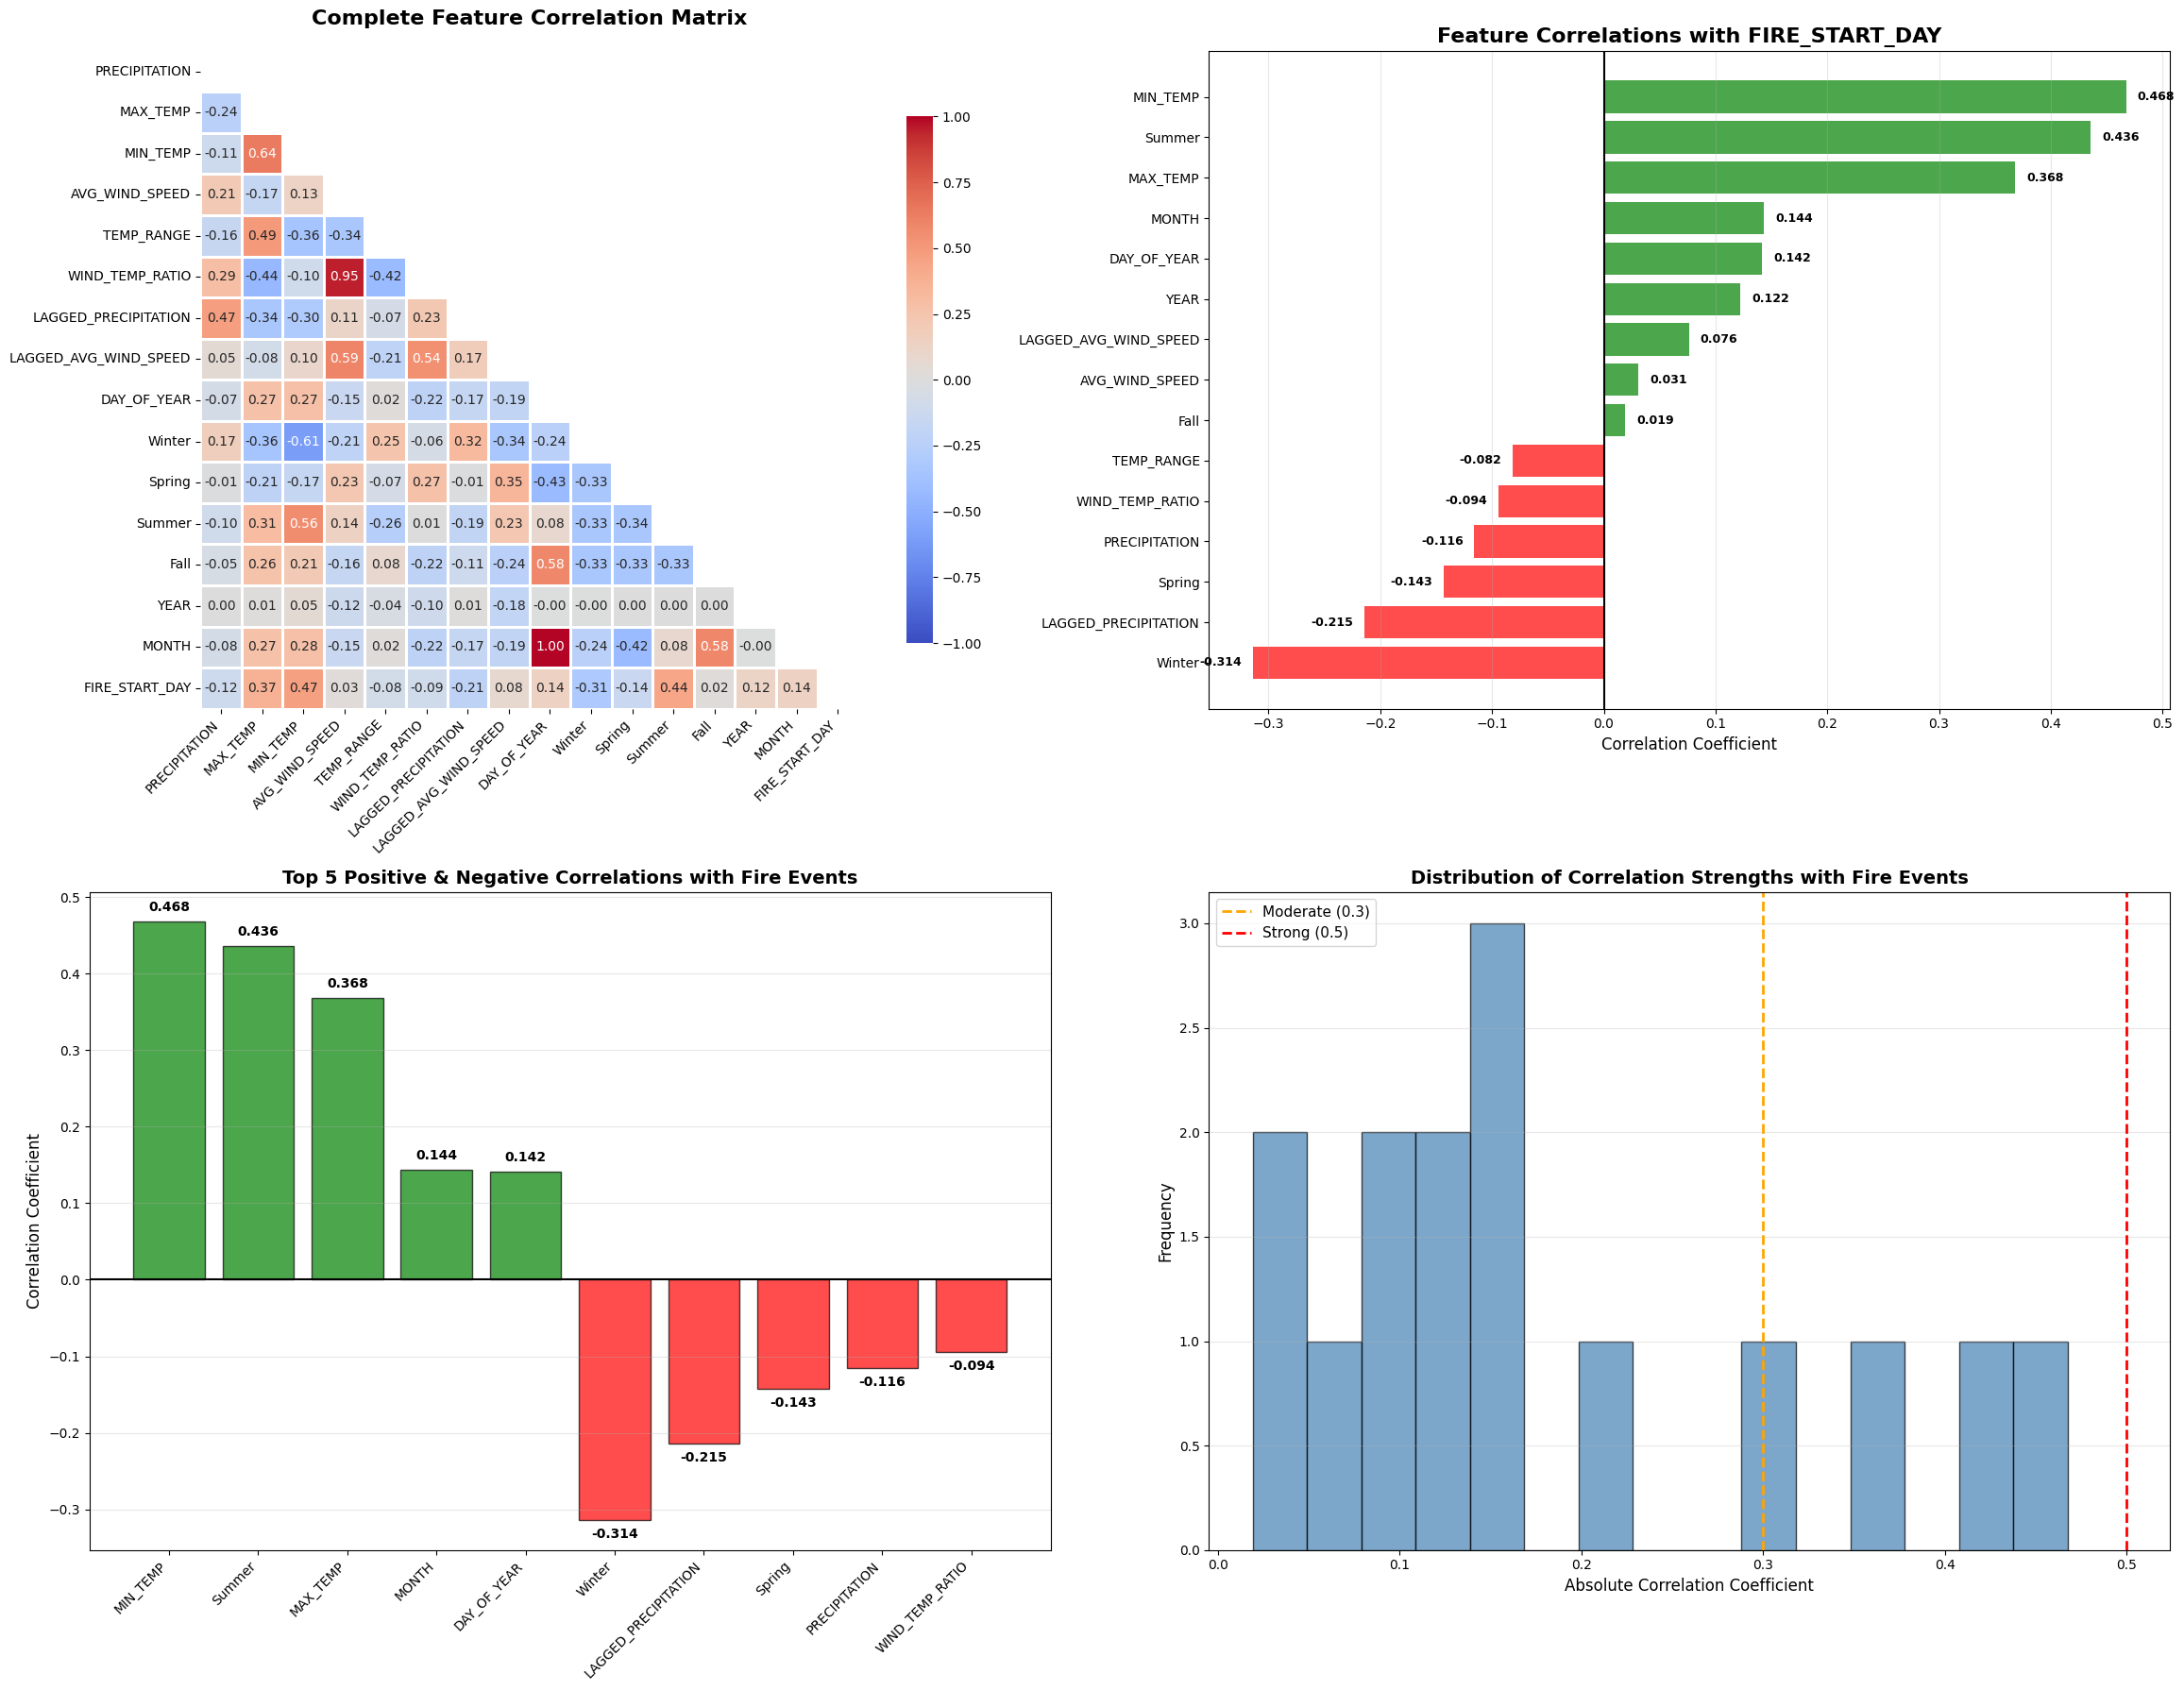


2. MULTICOLLINEARITY ANALYSIS:
------------------------------------------------------------
High correlations between features (potential multicollinearity):

   DAY_OF_YEAR               <-> MONTH                     :  0.996
   AVG_WIND_SPEED            <-> WIND_TEMP_RATIO           :  0.951

3. CORRELATION SUMMARY STATISTICS:
------------------------------------------------------------
   Mean absolute correlation: 0.1846
   Median absolute correlation: 0.1417
   Max absolute correlation: 0.4676
   Min absolute correlation: 0.0190
   Features with |correlation| > 0.3: 4
   Features with |correlation| > 0.5: 0

4. COEFFICIENT vs CORRELATION COMPARISON:
------------------------------------------------------------
Feature                   Correlation    LR Coefficient    Ratio
------------------------------------------------------------
MIN_TEMP                      0.4676        0.0790          0.17
Summer                        0.4360        0.1004          0.23
MAX_TEMP           

In [19]:
print("="*60)
print("CORRELATION ANALYSIS FOR LINEAR REGRESSION")
print("="*60)

# Calculate correlation matrix for all features including target
correlation_data = df[FEATURE_COLUMNS + [TARGET_COLUMN]].copy()
corr_matrix = correlation_data.corr()

# Get correlations with target variable
target_correlations = corr_matrix[TARGET_COLUMN].sort_values(ascending=False)

print("\n1. FEATURE CORRELATIONS WITH FIRE_START_DAY:")
print("-" * 60)
for feature, corr_value in target_correlations.items():
    if feature != TARGET_COLUMN:
        strength = "Strong" if abs(corr_value) > 0.5 else "Moderate" if abs(corr_value) > 0.3 else "Weak"
        direction = "Positive" if corr_value > 0 else "Negative"
        print(f"{feature:25} {corr_value:7.4f}  ({strength} {direction})")

# Create comprehensive correlation visualizations
fig = plt.figure(figsize=(24, 18))

# Plot 1: Full Correlation Heatmap
ax1 = plt.subplot(2, 2, 1)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax1,
            vmin=-1, vmax=1)
ax1.set_title('Complete Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# Plot 2: Correlation with Fire Events (Bar Chart)
ax2 = plt.subplot(2, 2, 2)
target_corr_sorted = target_correlations.drop(TARGET_COLUMN).sort_values()
colors = ['red' if x < 0 else 'green' for x in target_corr_sorted.values]
bars = ax2.barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors, alpha=0.7)
ax2.set_yticks(range(len(target_corr_sorted)))
ax2.set_yticklabels(target_corr_sorted.index)
ax2.set_xlabel('Correlation Coefficient', fontsize=12)
ax2.set_title('Feature Correlations with FIRE_START_DAY', fontsize=16, fontweight='bold')
ax2.axvline(x=0, color='black', linewidth=1.5)
ax2.grid(True, alpha=0.3, axis='x')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, target_corr_sorted.values)):
    ax2.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontweight='bold', fontsize=9)

# Plot 3: Top Positive and Negative Correlations
ax3 = plt.subplot(2, 2, 3)
top_positive = target_correlations.drop(TARGET_COLUMN).nlargest(5)
top_negative = target_correlations.drop(TARGET_COLUMN).nsmallest(5)
top_features = pd.concat([top_positive, top_negative])

x_pos = np.arange(len(top_features))
colors_top = ['green' if x > 0 else 'red' for x in top_features.values]
bars3 = ax3.bar(x_pos, top_features.values, color=colors_top, alpha=0.7, edgecolor='black')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(top_features.index, rotation=45, ha='right')
ax3.set_ylabel('Correlation Coefficient', fontsize=12)
ax3.set_title('Top 5 Positive & Negative Correlations with Fire Events', fontsize=14, fontweight='bold')
ax3.axhline(y=0, color='black', linewidth=1.5)
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars3, top_features.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.01),
             f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=10)

# Plot 4: Correlation Strength Distribution
ax4 = plt.subplot(2, 2, 4)
corr_values = target_correlations.drop(TARGET_COLUMN).abs().values
ax4.hist(corr_values, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(x=0.3, color='orange', linestyle='--', linewidth=2, label='Moderate (0.3)')
ax4.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Strong (0.5)')
ax4.set_xlabel('Absolute Correlation Coefficient', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Correlation Strengths with Fire Events', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional Analysis: Multicollinearity Check
print("\n2. MULTICOLLINEARITY ANALYSIS:")
print("-" * 60)
print("High correlations between features (potential multicollinearity):\n")

# Find feature pairs with high correlation (excluding target)
high_corr_pairs = []
for i in range(len(FEATURE_COLUMNS)):
    for j in range(i+1, len(FEATURE_COLUMNS)):
        feat1 = FEATURE_COLUMNS[i]
        feat2 = FEATURE_COLUMNS[j]
        corr_val = corr_matrix.loc[feat1, feat2]
        if abs(corr_val) > 0.7:  # Threshold for high correlation
            high_corr_pairs.append((feat1, feat2, corr_val))

if high_corr_pairs:
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"   {feat1:25} <-> {feat2:25} : {corr_val:6.3f}")
else:
    print("   No high multicollinearity detected (threshold > 0.7)")

# Summary Statistics
print("\n3. CORRELATION SUMMARY STATISTICS:")
print("-" * 60)
abs_correlations = target_correlations.drop(TARGET_COLUMN).abs()
print(f"   Mean absolute correlation: {abs_correlations.mean():.4f}")
print(f"   Median absolute correlation: {abs_correlations.median():.4f}")
print(f"   Max absolute correlation: {abs_correlations.max():.4f}")
print(f"   Min absolute correlation: {abs_correlations.min():.4f}")
print(f"   Features with |correlation| > 0.3: {(abs_correlations > 0.3).sum()}")
print(f"   Features with |correlation| > 0.5: {(abs_correlations > 0.5).sum()}")

# Compare Linear Regression Coefficients with Correlations
print("\n4. COEFFICIENT vs CORRELATION COMPARISON:")
print("-" * 60)
print("Feature                   Correlation    LR Coefficient    Ratio")
print("-" * 60)
comparison_df = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Correlation': [target_correlations[f] for f in FEATURE_COLUMNS],
    'Coefficient': lr_model.coef_
})
comparison_df['Ratio'] = comparison_df['Coefficient'] / (comparison_df['Correlation'] + 1e-10)
comparison_df = comparison_df.sort_values('Correlation', key=abs, ascending=False)

for _, row in comparison_df.iterrows():
    print(f"{row['Feature']:25} {row['Correlation']:10.4f}    {row['Coefficient']:10.4f}    {row['Ratio']:10.2f}")

print("\n" + "="*60)
print("CORRELATION ANALYSIS COMPLETE")
print("="*60)